## Setup, Loading Data and CDFs

In [1]:
DATA_NAME = 'syntheticMRI2D-coronal' 
TRANSFORM = 'wavelet-diagonal'
CHANNEL = ''

In [2]:
path_list = DATA_NAME.split("-") + TRANSFORM.split("-")
if CHANNEL:
    path_list.append(CHANNEL)
print(f"Name the notebook:\n{'_'.join(path_list[::-1])}.ipynb")
FULL_DATA_NAME='-'.join(path_list)

Name the notebook:
diagonal_wavelet_coronal_syntheticMRI2D.ipynb


In [3]:
import git
from pathlib import Path
import os

ROOT_DIR = Path(git.Repo('.', search_parent_directories=True).working_tree_dir)
CWD = os.path.join(ROOT_DIR, "results", "case-studies", *path_list)

assert CWD == os.getcwd()
Path(os.path.join(CWD, "CSVs")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "plots")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "cache")).mkdir(exist_ok=True)

GROUP = 'layer' if TRANSFORM.split("-")[0] == 'wavelet' else ('band' if TRANSFORM.split("-")[0] == 'fourier' else 'error')
RERUN = False
SKIP_OPTIMIZE_STEP = False
CWD

'/Users/brandonmarks/Desktop/hierarchical-bayesian-model-validation/results/case-studies/syntheticMRI2D/coronal/wavelet/diagonal'

In [4]:
os.chdir(os.path.join(ROOT_DIR, "utilities"))
from testing import * # If MATLAB is not installed, open utilities and set to False
from plotting import *
os.chdir(CWD)
np.random.seed(0)

In [5]:
group_data_map = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data", f'{FULL_DATA_NAME}.pickle'))
group_total_samples = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data", f'{FULL_DATA_NAME}-size.pickle'))

In [6]:
if 'fourier' in TRANSFORM:
    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)[::3]
elif 'wavelet' in TRANSFORM:
    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)

cdfs_dir = os.path.join(ROOT_DIR, "results", "CDFs")
cdfs_list = sorted([os.path.join(cdfs_dir, i) for i in os.listdir(cdfs_dir)])
all_cdfs = combine_pickles(cdfs_list[0])
for cdf_dir in cdfs_list[:6]: # TODO For quick testing purposes. Currently excluding 20000 CDFs. Use cdfs_list[5:6] to access CDFs/_test
    all_cdfs = all_cdfs | combine_pickles(cdf_dir)
    
# group_data_map = {g : group_data_map[g][::100] for g in GROUPS} # TODO For quick testing purposes
group_total_samples

{2: 0,
 3: 19544,
 4: 177766,
 5: 820632,
 6: 3670424,
 7: 15384514,
 8: 62976002,
 9: 254776200}

Running 12760 CDFs


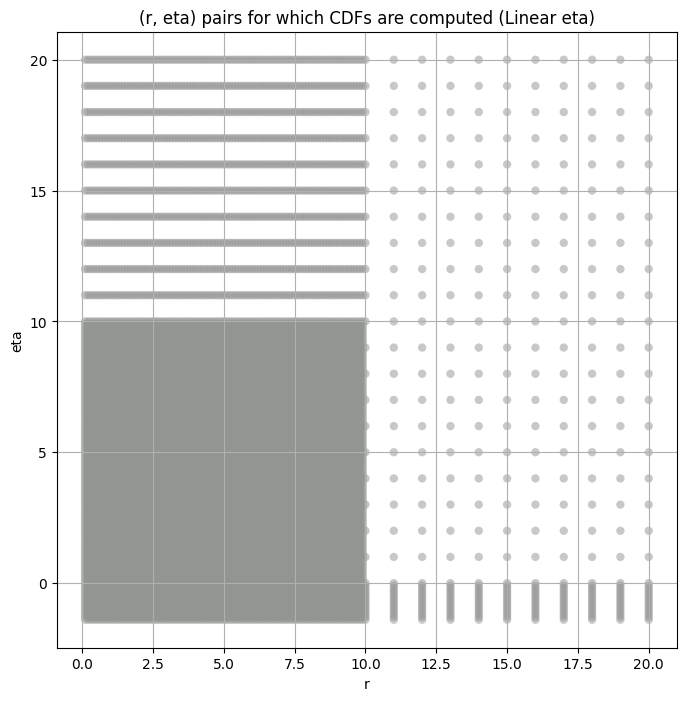

(r,eta),cdf    r  eta  \
0  ((0.1, -1.4), <scipy.interpolate._fitpack2.Int...  0.1 -1.4   
1  ((0.1, -1.3), <scipy.interpolate._fitpack2.Int...  0.1 -1.3   
2  ((0.1, -1.2), <scipy.interpolate._fitpack2.Int...  0.1 -1.2   
3  ((0.1, -1.1), <scipy.interpolate._fitpack2.Int...  0.1 -1.1   
4  ((0.1, -1.0), <scipy.interpolate._fitpack2.Int...  0.1 -1.0   

                                                 cdf      variance  \
0  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.628800e+06   
1  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.991680e+07   
2  <scipy.interpolate._fitpack2.InterpolatedUniva...  2.395008e+08   
3  <scipy.interpolate._fitpack2.InterpolatedUniva...  1.037837e+09   
4  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.632429e+09   

        kurtosis  
0  554265.000000  
1   96192.272727  
2   29390.000000  
3   11997.692308  
4    5874.890110

In [7]:
warnings.filterwarnings('ignore', category=RuntimeWarning)

all_cdfs_df = create_kurt_var_ksstat_df(all_cdfs)
fine_cdfs_df = all_cdfs_df.copy()
all_cdfs_df = all_cdfs_df[(np.round(all_cdfs_df['r'], 1) == all_cdfs_df['r']) & (np.round(all_cdfs_df['eta'], 1) == all_cdfs_df['eta'])]
all_cdfs_df = all_cdfs_df.reset_index(drop=True)
all_cdfs = {x[0] : x[1] for x in all_cdfs_df["(r,eta),cdf"]}
                                             
var_values_dict = dict()
kurt_values_dict = dict()
master_df = pd.DataFrame(columns=[GROUP]).set_index(GROUP)
temp_cdf = all_cdfs_df
print(f"Running {all_cdfs_df.shape[0]} CDFs")
create_scatter_plot(all_cdfs_df);
all_cdfs_df.head()

## Bootstrapping the Variance and Kurtosis

In [8]:
n_bootstrap = int(1e5) # TODO For quick testing purposes
bootstrap_size = int(1e4) # TODO For quick testing purposes
ci = 0.99

In [9]:
bootstrap_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))
master_df_var_kurt_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

if RERUN or not master_df_var_kurt_path.exists(): # TODO For quick testing purposes
    for group in GROUPS:
        print(f'{GROUP.capitalize()} {group}')
        obs_var, var_lower, var_upper, var_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                n_bootstrap=n_bootstrap, 
                                                                                bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                metric= np.var, 
                                                                                ci=ci)
        obs_kurt, kurt_lower, kurt_upper, kurt_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                    n_bootstrap=n_bootstrap, 
                                                                                    bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                    metric= stats.kurtosis, ci=ci)  
        master_df.loc[group, 'obs_var'], master_df.loc[group, 'var_lower'], master_df.loc[group, 'var_upper'] = obs_var, var_lower, var_upper
        master_df.loc[group, 'obs_kurt'], master_df.loc[group, 'kurt_lower'], master_df.loc[group, 'kurt_upper'] = obs_kurt, kurt_lower, kurt_upper
        master_df.loc[group, 'total_samples'] = group_total_samples[group]

    master_df['total_samples'] = master_df['total_samples'].astype(int)
    master_df.to_csv(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

master_df = pd.read_csv(master_df_var_kurt_path, index_col=GROUP)
var_kurt_df = pd.read_csv(bootstrap_path, index_col=GROUP)
master_df

Layer 2


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 3


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 4


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 5


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 6


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 7


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 8


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 9


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

obs_var      var_lower      var_upper    obs_kurt  kurt_lower  \
layer                                                                        
2                NaN            NaN            NaN         NaN         NaN   
3       79735.640000   76177.540000   83407.180000    1.053642    0.821076   
4      129412.030000  124235.086000  134673.400000    0.427118    0.221106   
5       38390.297000   36425.370000   40415.066000    2.094468    1.571328   
6       12667.709000   11567.081000   13817.150000    9.891224    8.672808   
7        1314.776100    1189.517000    1448.287100   12.748015   10.145151   
8          56.887344      47.695780      76.797424   91.038864   11.893420   
9           2.228922       1.633102       4.197240  495.823330   16.132544   

        kurt_upper  total_samples  
layer                              
2              NaN              0  
3         1.318261          19544  
4         0.664810         177766  
5         2.786164         820632  
6        11.163638        3670424  
7        20.341785       15384514  
8       375.473180       62976002  
9      1411.289900      254776200

## Initial Grid Search and Hypothesis Test Plots

In [10]:
EXCLUDE_CUTOFFS = [0, 25, 50, 75, 100, 150, 200, 250, 300, 350, 500] # TODO For quick testing purposes
SCALE_CAP = 1e5

In [11]:
augmented_var_df_path = Path(os.path.join(CWD, "CSVs", "augmented_var_df.csv"))
augmented_var_df = var_kurt_df[['obs_var']].copy()
augmented_var_df
for val in EXCLUDE_CUTOFFS:
    temp_arr = []
    for group in GROUPS:
        if val != 0:
            temp_arr.append(np.var(group_data_map[group][val:-val]))
        else:
            temp_arr.append(np.var(group_data_map[group]))

    augmented_var_df[f"var_exclude_{val}"] = temp_arr
augmented_var_df

obs_var  var_exclude_0  var_exclude_25  var_exclude_50  \
layer                                                                 
2                NaN            NaN             NaN             NaN   
3       79735.640000   79735.640625    76783.101562    74547.867188   
4      129412.030000  129412.031250   128250.664062   127335.992188   
5       38390.297000   38390.296875    37800.820312    37375.437500   
6       12667.709000   12667.708984    12355.482422    12092.304688   
7        1314.776100    1314.776123     1269.202393     1236.966064   
8          56.887344      56.887344       49.719463       48.000904   
9           2.228922       2.228922        1.704126        1.619977   

       var_exclude_75  var_exclude_100  var_exclude_150  var_exclude_200  \
layer                                                                      
2                 NaN              NaN              NaN              NaN   
3        72726.890625     71147.695312     68313.953125     65877.210938   
4       126523.796875    125776.835938    124432.070312    123206.375000   
5        37008.289062     36675.722656     36077.796875     35547.167969   
6        11853.237305     11631.905273     11229.593750     10869.453125   
7         1208.668457      1182.999268      1137.228516      1096.773804   
8           46.673580        45.542099        43.632526        42.022293   
9            1.559603         1.510906         1.433278         1.371612   

       var_exclude_250  var_exclude_300  var_exclude_350  var_exclude_500  
layer                                                                      
2                  NaN              NaN              NaN              NaN  
3         63647.636719     61587.093750     59655.363281     54467.652344  
4        122072.625000    121015.218750    120014.906250    117285.398438  
5         35061.035156     34609.628906     34186.867188     33055.511719  
6         10542.887695     10242.474609      9963.548828      9225.614258  
7          1060.342529      1027.106567       996.533630       917.351929  
8            40.612053        39.349949        38.205219        35.283657  
9             1.320027         1.275495         1.236237         1.140090

####
Layer  2
####
Layer  3


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 0 0.0054359190794831536 79735.64


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 25 0.006436519002448349 76783.1


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 50 0.008156907224439916 74547.87


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 75 0.00963209085632933 72726.89


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 100 0.010937879372994945 71147.695


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 150 0.013395052129246 68313.95


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 200 0.015553599026480076 65877.21


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 250 0.017673180577331388 63647.637


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 300 0.01965836117964912 61587.094


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 350 0.021604818253368657 59655.363


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 500 0.028722244645432222 54467.652
Number of samples: 19544, Without approximation : 19544


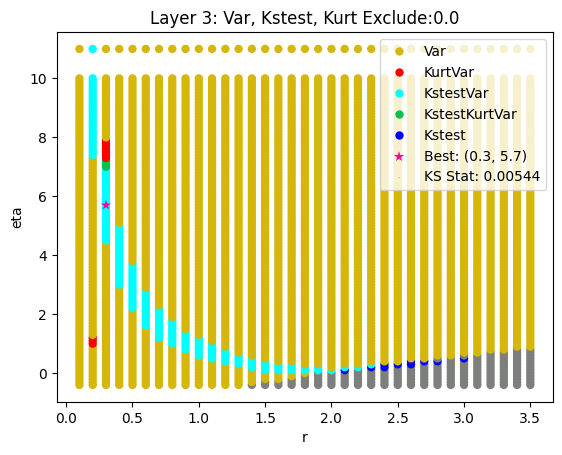

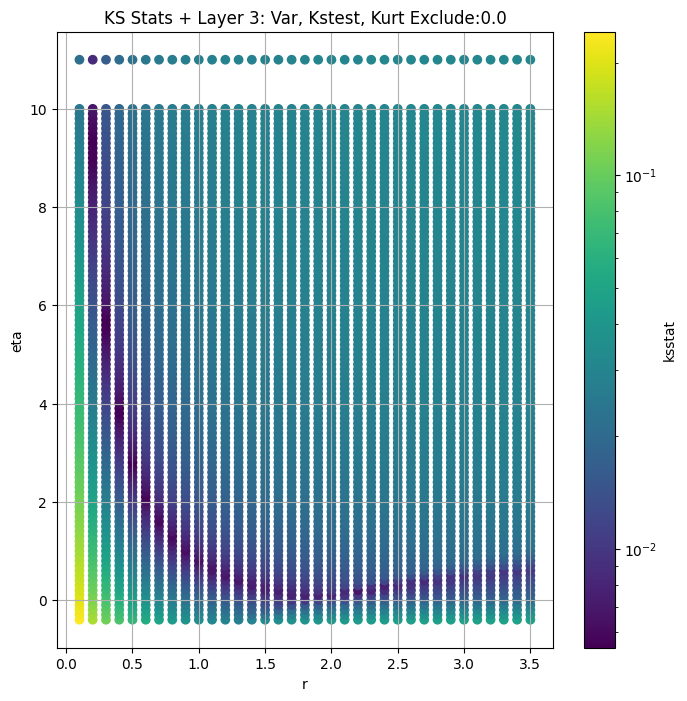

####
Layer  4


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 0 0.007301494278806858 129412.03


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 25 0.007631402512773194 128250.664


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 50 0.007886545495741026 127335.99


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 75 0.008120867730402881 126523.8


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 100 0.00834373410827638 125776.836


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 150 0.008694727578395067 124432.07


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 200 0.009044067819679036 123206.375


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 250 0.00935498857051753 122072.625


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 300 0.009635964067168615 121015.22


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 350 0.009885229045482502 120014.91


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 500 0.01248530841319273 117285.4
Number of samples: 100000, Without approximation : 177766


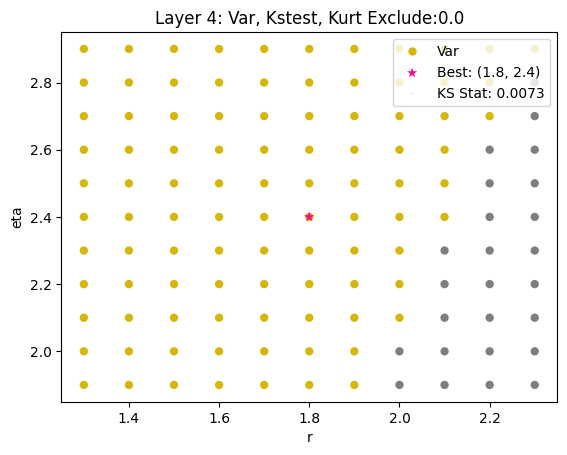

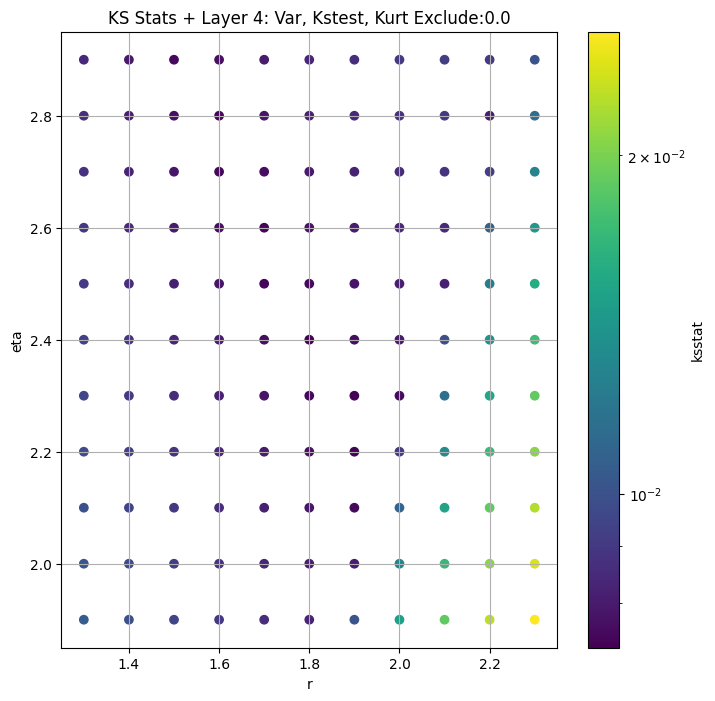

####
Layer  5


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 0 0.0018820774365510481 38390.297


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 25 0.001616903188929597 37800.82


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 50 0.0014325750817678617 37375.438


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 75 0.0016633701429478627 37008.29


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 100 0.0018739808518819512 36675.723


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 150 0.00222706309650813 36077.797


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 200 0.0027033439951871796 35547.168


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 250 0.003123525794207831 35061.035


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 300 0.0035459139161285614 34609.63


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 350 0.004031304534794746 34186.867


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 500 0.00605536879245816 33055.51
Number of samples: 100000, Without approximation : 820632


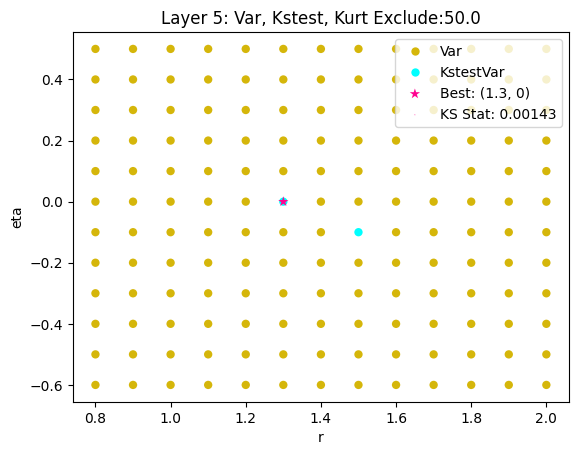

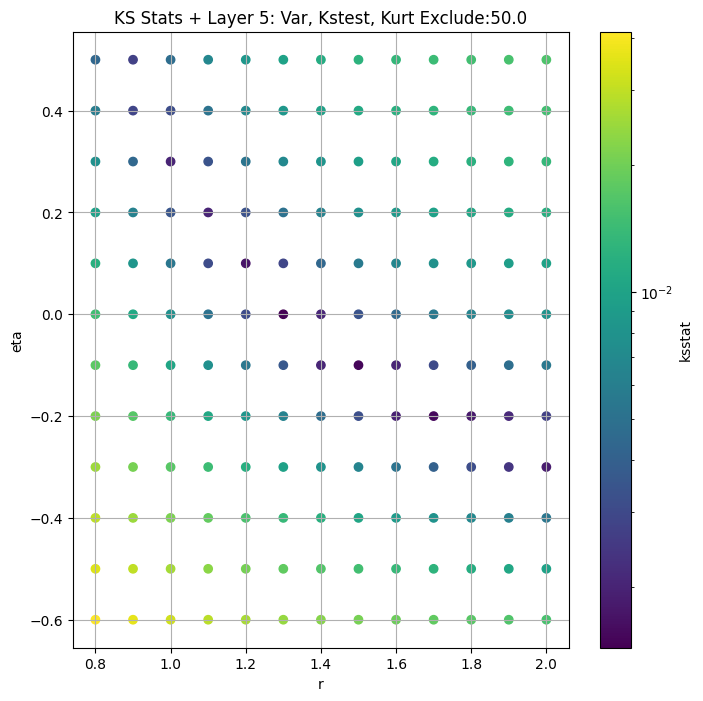

####
Layer  6


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 0 0.00711147974925741 12667.709


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 25 0.006977830644321559 12355.482


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 50 0.007085223036003563 12092.305


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 75 0.006579137351884978 11853.237


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 100 0.006666598746439878 11631.905


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 150 0.006281574902295639 11229.594


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 200 0.007087806161284793 10869.453


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 250 0.00593465051401465 10542.888


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 300 0.006344084255568649 10242.475


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 350 0.006847428609162071 9963.549


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 500 0.008178069788066011 9225.614
Number of samples: 100000, Without approximation : 3670424


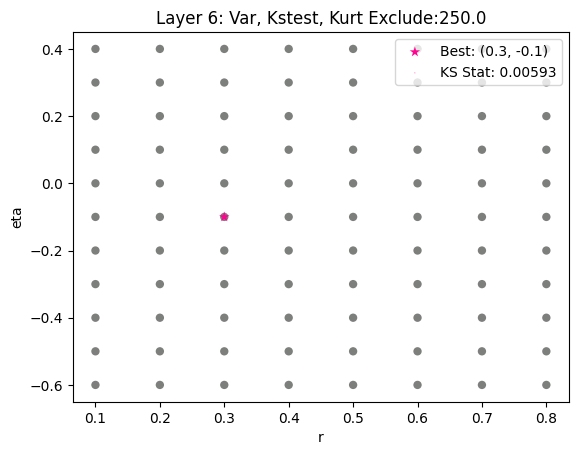

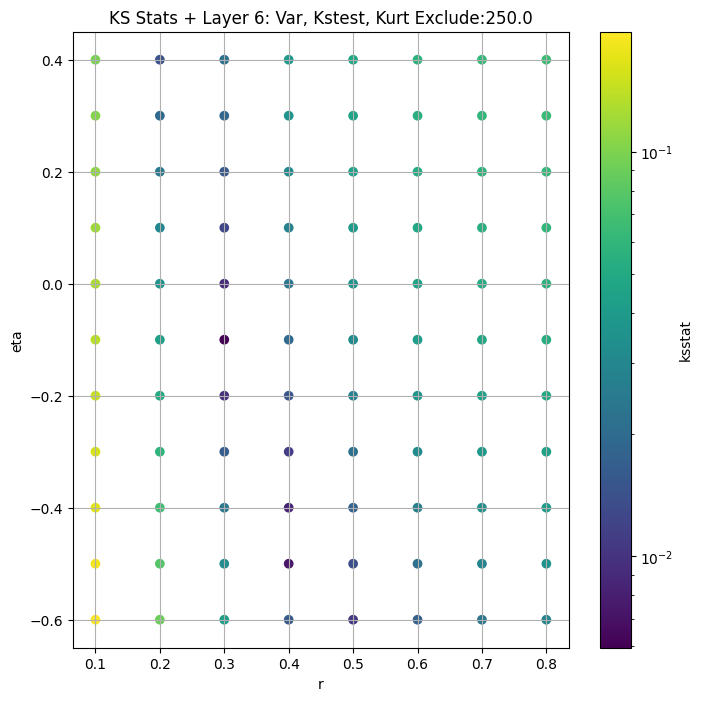

####
Layer  7


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 0 0.0035643400859762253 1314.7761


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 25 0.002771648194247911 1269.2024


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 50 0.004537520819827168 1236.9661


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 75 0.005648901824206909 1208.6685


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 100 0.004316442737430037 1182.9993


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 150 0.004243452915806301 1137.2285


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 200 0.004958604438112264 1096.7738


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 250 0.005291810031216815 1060.3425


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 300 0.005920395321361793 1027.1066


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 350 0.006282947208494087 996.5336


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 500 0.007927544826169974 917.3519
Number of samples: 100000, Without approximation : 15384514


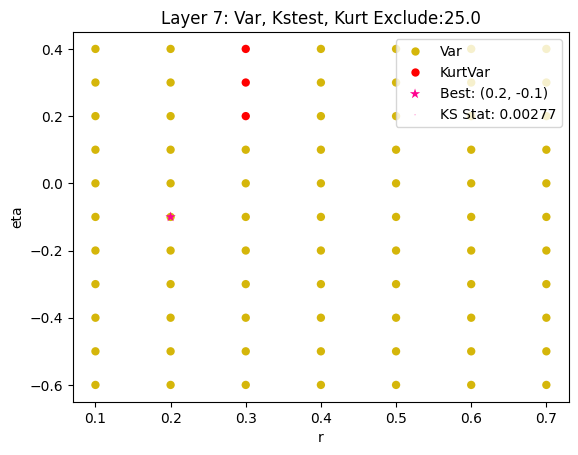

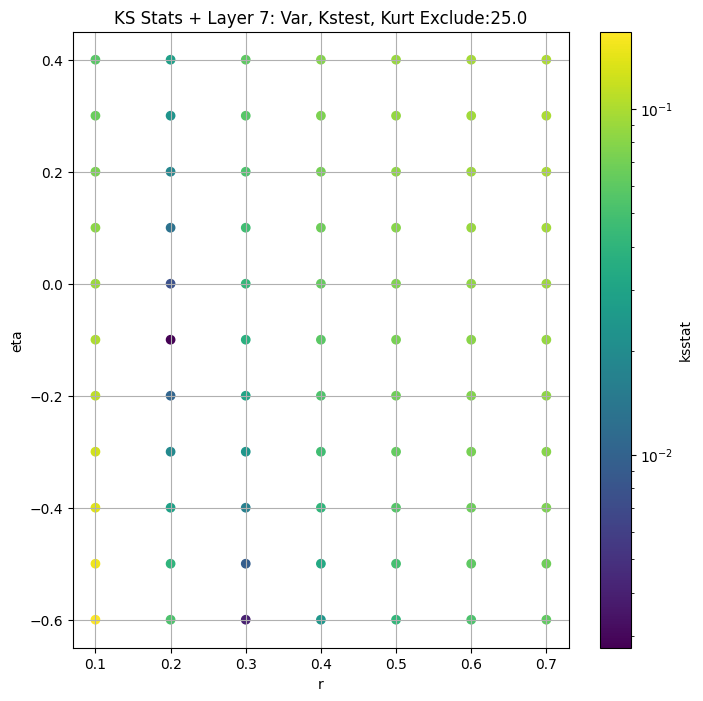

####
Layer  8


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 0 0.0021501894020271584 56.887344


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 25 0.0039397049471706636 49.719463


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 50 0.004128833967460388 48.000904


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 75 0.0036783551099769385 46.67358


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 100 0.004332738932104285 45.5421


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 150 0.005193438321399513 43.632526


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 200 0.0062432064313053814 42.022293


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 250 0.00603423723795371 40.612053


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 300 0.006911253136090291 39.34995


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 350 0.007223323286515121 38.20522


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 500 0.008618922608365054 35.283657
Number of samples: 100000, Without approximation : 62976002


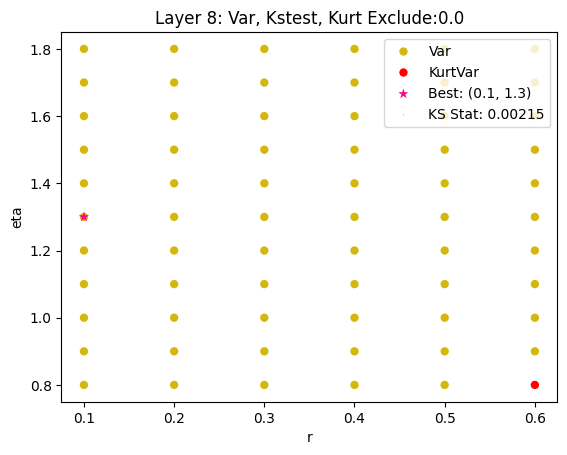

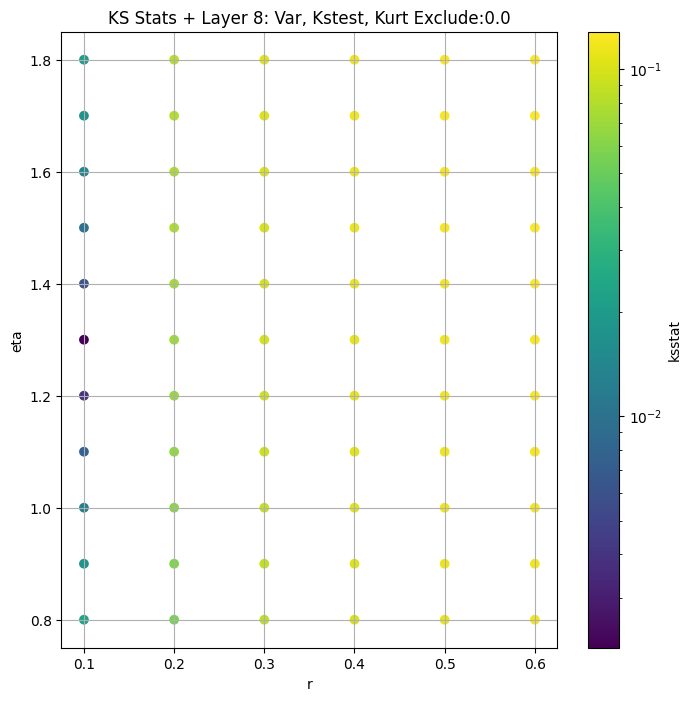

####
Layer  9


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 0 0.019725312118836394 2.2289224


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 25 0.012805564328019381 1.7041258


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 50 0.011294395619785458 1.6199775


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 75 0.01041649287779095 1.5596027


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 100 0.009366381826511117 1.5109055


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 150 0.008050222638600224 1.4332783


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 200 0.006766952345733157 1.3716116


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 250 0.005743650686145407 1.3200268


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 300 0.005503076085138003 1.2754952


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 350 0.0060452061606548774 1.2362374


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 500 0.007681848666819677 1.1400895
Number of samples: 100000, Without approximation : 254776200


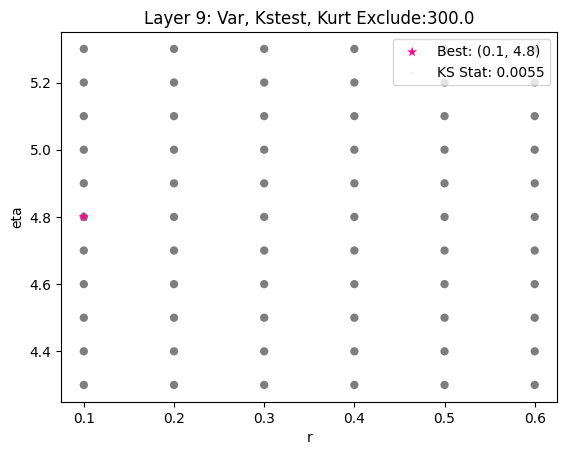

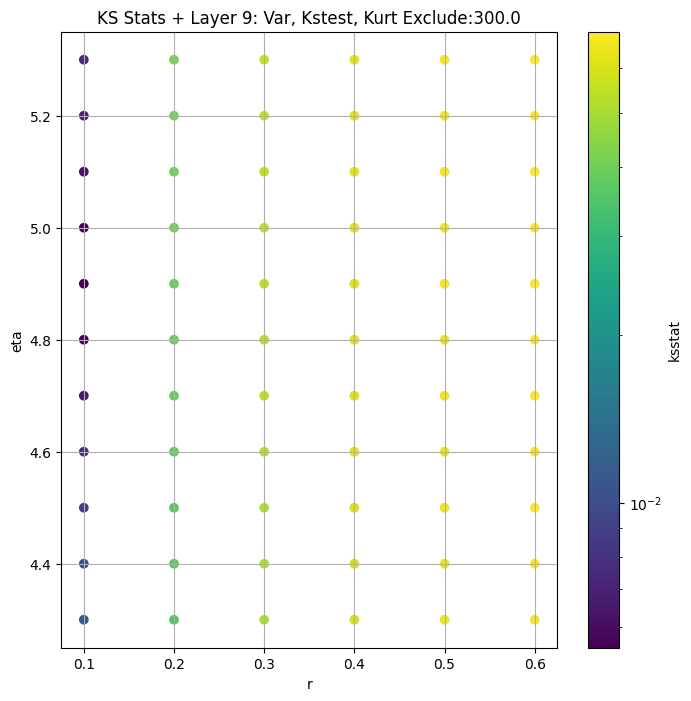

obs_var      var_lower      var_upper    obs_kurt  kurt_lower  \
layer                                                                        
2                NaN            NaN            NaN         NaN         NaN   
3       79735.640000   76177.540000   83407.180000    1.053642    0.821076   
4      129412.030000  124235.086000  134673.400000    0.427118    0.221106   
5       38390.297000   36425.370000   40415.066000    2.094468    1.571328   
6       12667.709000   11567.081000   13817.150000    9.891224    8.672808   
7        1314.776100    1189.517000    1448.287100   12.748015   10.145151   
8          56.887344      47.695780      76.797424   91.038864   11.893420   
9           2.228922       1.633102       4.197240  495.823330   16.132544   

        kurt_upper  total_samples  kstest_stat_initial  initial_r  \
layer                                                               
2              NaN              0                  NaN        NaN   
3         1.318261          19544             0.005436        0.3   
4         0.664810         177766             0.007301        1.8   
5         2.786164         820632             0.001433        1.3   
6        11.163638        3670424             0.005935        0.3   
7        20.341785       15384514             0.002772        0.2   
8       375.473180       62976002             0.002150        0.1   
9      1411.289900      254776200             0.005503        0.1   

       initial_eta  initial_scale  initial_exclude_cutoff  best_augmented_var  \
layer                                                                           
2              NaN            NaN                     NaN                 NaN   
3              5.7   1.710793e+00                     0.0        79735.640000   
4              2.4   8.907592e+04                     0.0       129412.030000   
5              0.0   3.590717e+04                    50.0        37375.438000   
6             -0.1   3.077395e+01                   250.0        10542.888000   
7             -0.1   2.289326e-02                    25.0         1269.202400   
8              1.3   4.500508e-14                     0.0           56.887344   
9              4.8   6.555100e-19                   300.0            1.275495   

       kstest_stat_cutoff_0.05  
layer                           
2                          NaN  
3                     0.009706  
4                     0.003220  
5                     0.001499  
6                     0.000709  
7                     0.000346  
8                     0.000171  
9                     0.000085

In [12]:
master_df_combo_path = Path(os.path.join(CWD, "CSVs", "master_df_combo.csv"))
rEtaKsstats_dict_path = Path(os.path.join(CWD, "cache", "rEtaKsstats_dict.pickle"))

rEtaKsstats_dict = dict()

if RERUN or not master_df_combo_path.exists():
    sorted_params = sorted(all_cdfs)
    ksstats_dict = dict()

    for i, group in enumerate(GROUPS): # TODO For quick testing purposes
        print(f"####\n{GROUP.capitalize()} ", group)
        sample = group_data_map[group]
        if len(sample) == 0:
            continue
        group_cdfs_df = all_cdfs_df.copy()
        master_df.loc[group, 'kstest_stat_initial'] = 1

        for j in range(len(EXCLUDE_CUTOFFS)):

            exclude_cutoff = EXCLUDE_CUTOFFS[j]
            exclude_cutoff = int(exclude_cutoff)

            if exclude_cutoff == 0:
                augmented_var = np.var(group_data_map[group]) 
            else:
                augmented_var = np.var(group_data_map[group][exclude_cutoff:-exclude_cutoff])
                if augmented_var == np.var(group_data_map[group]):
                    continue 
                
            group_cdfs_df['scale'] = np.clip((augmented_var / group_cdfs_df['variance']), 0,  SCALE_CAP)
            ksstats, initial_param, min_stat = gridsearch(sample, all_cdfs, debug=True, scales=group_cdfs_df['scale'])
            augmented_var_df.loc[group, f"kstest_stat_{exclude_cutoff}"] = min_stat
            group_cdfs_df[f'ksstat_exclude_{exclude_cutoff}'] = ksstats
            
            print(group, exclude_cutoff, min_stat, augmented_var)
            
            if (min_stat < master_df.loc[group, 'kstest_stat_initial']) and not np.isclose(min_stat, master_df.loc[group, 'kstest_stat_initial'], 1e-6):
                inital_min_stat = min_stat
                inital_best_param = initial_param
                master_df.loc[group, 'kstest_stat_initial'] = min_stat
                initial_scale = group_cdfs_df.loc[(group_cdfs_df["r"] ==  initial_param[0]) & (group_cdfs_df["eta"] ==  initial_param[1])]["scale"].iloc[0]
                master_df.loc[group, 'initial_r'], master_df.loc[group, 'initial_eta'] = initial_param
                master_df.loc[group, 'initial_scale'] = initial_scale
                master_df.loc[group, 'initial_exclude_cutoff'] = exclude_cutoff
                master_df.loc[group, 'best_augmented_var'] = augmented_var
        
        ksstats = group_cdfs_df[f"ksstat_exclude_{int(master_df.loc[group, 'initial_exclude_cutoff'])}"]
            
        print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
        
        cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
        master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

        best_scales = np.clip((master_df.loc[group, 'best_augmented_var'] / group_cdfs_df['variance']), 0,  SCALE_CAP)

        group_cdfs_df['variance'] = group_cdfs_df['variance'] * best_scales
        group_cdfs_df['kurtosis'] = group_cdfs_df['kurtosis'] * best_scales

        group_cdfs_df = add_tests_to_df(cdfs_df = group_cdfs_df, group = group, var_kurt_df = master_df, ksstats = ksstats).sort_values(['r', 'eta'])

        group_dict = {'r' : group_cdfs_df['r'], 'eta' : group_cdfs_df['eta']}
        group_dict.update({f'ksstat_exclude_{exclude_cutoff}' : group_cdfs_df[f'ksstat_exclude_{exclude_cutoff}'] for exclude_cutoff in EXCLUDE_CUTOFFS[:j+1]})
        rEtaKsstats_dict[group] = group_dict

        cols = ['pass_var', 'pass_kstest', 'pass_kurt']

        fig = combo_test_plot(group_cdfs_df, cols, 
                            plot_name=f"{GROUP.capitalize()} {group}: {', '.join([col[5:].capitalize() for col in cols])} Exclude:{master_df.loc[group, 'initial_exclude_cutoff']}", 
                            target_var = None,
                            best_param = inital_best_param,
                            best_ksstat=inital_min_stat
                            )
        
        fig.figure.savefig(os.path.join(CWD, "plots", f"full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=100)

        # Optional: 
        # Create plots of bootstrapped variance and kurtosis for varying confidence intervals
        # fig_var = create_ci_scatter_plot(group_cdfs_df, var_values_dict, metric='variance', group=group)
        # fig_kurt = create_ci_scatter_plot(group_cdfs_df, kurt_values_dict, metric='kurtosis', group=group)

        # fig_var.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_var)
        # fig_kurt.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_kurt)

    master_df.to_csv(master_df_combo_path)
    pd.to_pickle(rEtaKsstats_dict, rEtaKsstats_dict_path)
    augmented_var_df.to_csv(augmented_var_df_path)

augmented_var_df = pd.read_csv(augmented_var_df_path, index_col=GROUP)
master_df = pd.read_csv(master_df_combo_path, index_col=GROUP)
rEtaKsstats_dict = pd.read_pickle(rEtaKsstats_dict_path)
master_df

## Optimization

In [13]:
master_df['kstest_stat_best'] = master_df['kstest_stat_initial']
master_df[f'best_r'] = master_df['initial_r']
master_df[f'best_eta'] = master_df['initial_eta']
master_df[f'best_scale'] = master_df['initial_scale']
master_df[f'best_exclude_cutoff'] = master_df['initial_exclude_cutoff']

Layer 2
Layer 3


  0%|          | 0/702 [00:00<?, ?it/s]

Finding Minimum after computing 702 CDFs
layer 3, 0.0 + 100 = 100, ksstat: 0.01213183709887445, var: 71147.6953125


  0%|          | 0/702 [00:00<?, ?it/s]

Finding Minimum after computing 702 CDFs
layer 3, 0.0 + 75 = 75, ksstat: 0.010773630048548921, var: 72726.890625


  0%|          | 0/702 [00:00<?, ?it/s]

Finding Minimum after computing 702 CDFs
layer 3, 0.0 + 50 = 50, ksstat: 0.009302270839088078, var: 74547.8671875


  0%|          | 0/702 [00:00<?, ?it/s]

Finding Minimum after computing 702 CDFs
layer 3, 0.0 + 25 = 25, ksstat: 0.007598171726420744, var: 76783.1015625


  0%|          | 0/702 [00:00<?, ?it/s]

Finding Minimum after computing 702 CDFs
layer 3, 0.0 + 0 = 0, ksstat: 0.005420976824312758, var: 79735.640625
Number of samples: 19544, Without approximation : 19544


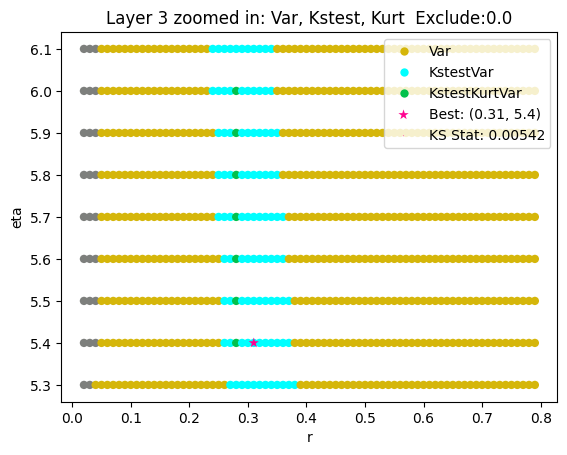

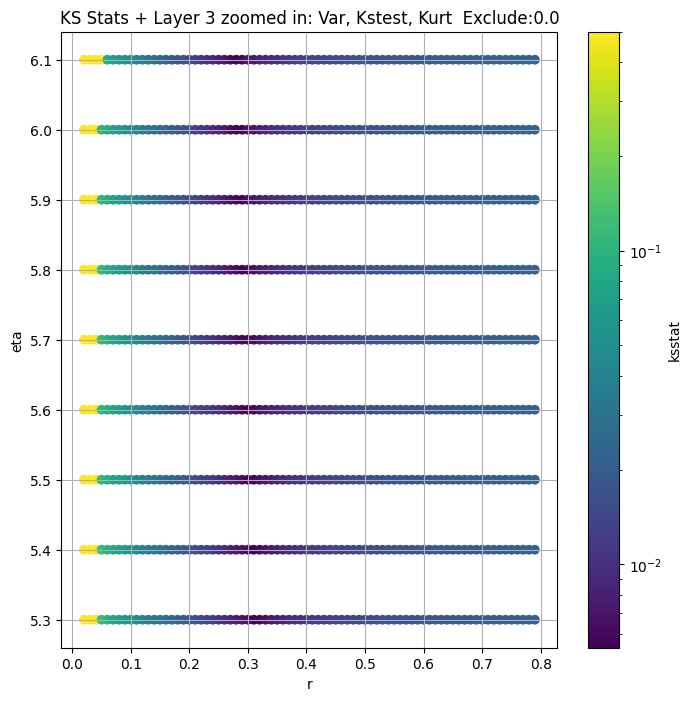

Layer 4


  0%|          | 0/657 [00:00<?, ?it/s]

Finding Minimum after computing 657 CDFs
layer 4, 0.0 + 100 = 100, ksstat: 0.009032100156000922, var: 125776.8359375


  0%|          | 0/657 [00:00<?, ?it/s]

Finding Minimum after computing 657 CDFs
layer 4, 0.0 + 75 = 75, ksstat: 0.008371331562866735, var: 126523.796875


  0%|          | 0/657 [00:00<?, ?it/s]

Finding Minimum after computing 657 CDFs
layer 4, 0.0 + 50 = 50, ksstat: 0.007886545495741026, var: 127335.9921875


  0%|          | 0/657 [00:00<?, ?it/s]

Finding Minimum after computing 657 CDFs
layer 4, 0.0 + 25 = 25, ksstat: 0.007603029947353304, var: 128250.6640625


  0%|          | 0/657 [00:00<?, ?it/s]

Finding Minimum after computing 657 CDFs
layer 4, 0.0 + 0 = 0, ksstat: 0.007256535901294825, var: 129412.03125
Number of samples: 100000, Without approximation : 177766


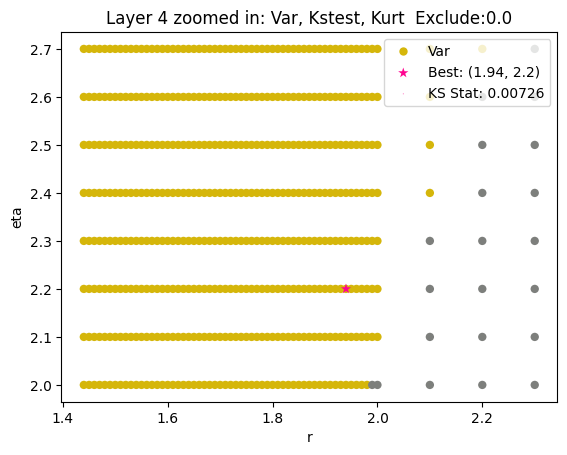

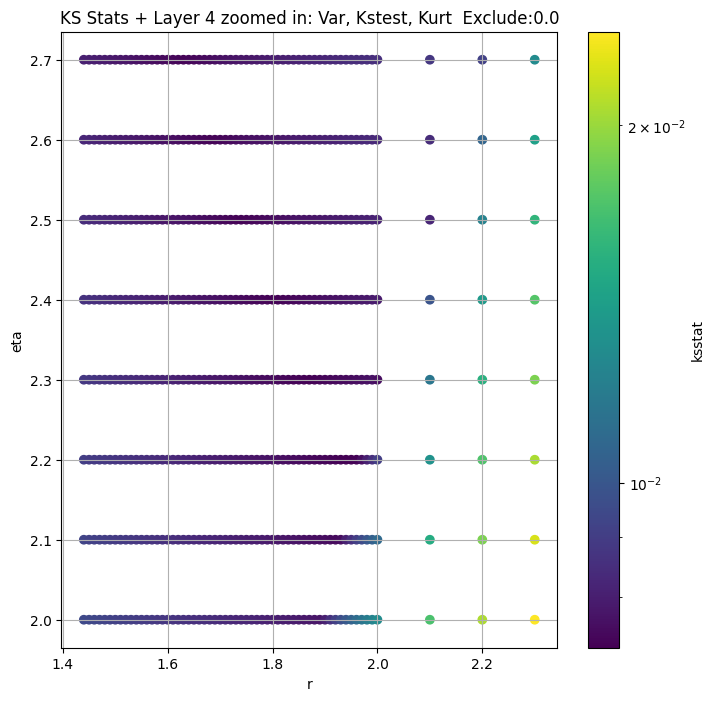

Layer 5


  0%|          | 0/1296 [00:00<?, ?it/s]

Finding Minimum after computing 1296 CDFs
layer 5, 50.0 + 100 = 150, ksstat: 0.0022190631028246866, var: 36077.796875


  0%|          | 0/1296 [00:00<?, ?it/s]

Finding Minimum after computing 1296 CDFs
layer 5, 50.0 + 75 = 125, ksstat: 0.002000588361173703, var: 36366.6953125


  0%|          | 0/1296 [00:00<?, ?it/s]

Finding Minimum after computing 1296 CDFs
layer 5, 50.0 + 50 = 100, ksstat: 0.0018178604139378381, var: 36675.72265625


  0%|          | 0/1296 [00:00<?, ?it/s]

Finding Minimum after computing 1296 CDFs
layer 5, 50.0 + 25 = 75, ksstat: 0.001599669693629329, var: 37008.2890625


  0%|          | 0/1296 [00:00<?, ?it/s]

Finding Minimum after computing 1296 CDFs
layer 5, 50.0 + 0 = 50, ksstat: 0.001390501454162538, var: 37375.4375


  0%|          | 0/1296 [00:00<?, ?it/s]

Finding Minimum after computing 1296 CDFs
layer 5, 50.0 + -25 = 25, ksstat: 0.0014196687920697004, var: 37800.8203125


  0%|          | 0/1296 [00:00<?, ?it/s]

Finding Minimum after computing 1296 CDFs
layer 5, 50.0 + -50 = 0, ksstat: 0.0018480722681055717, var: 38390.296875
Number of samples: 100000, Without approximation : 820632


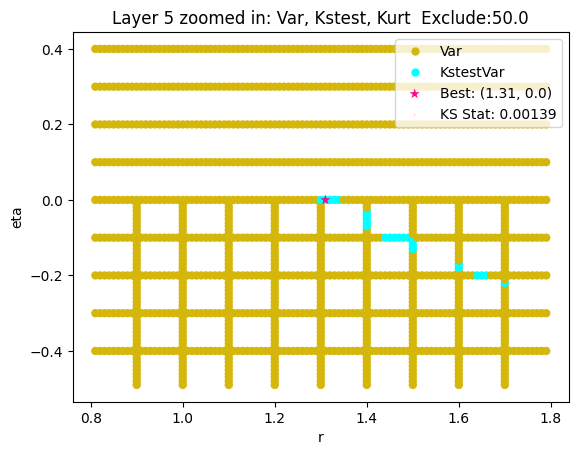

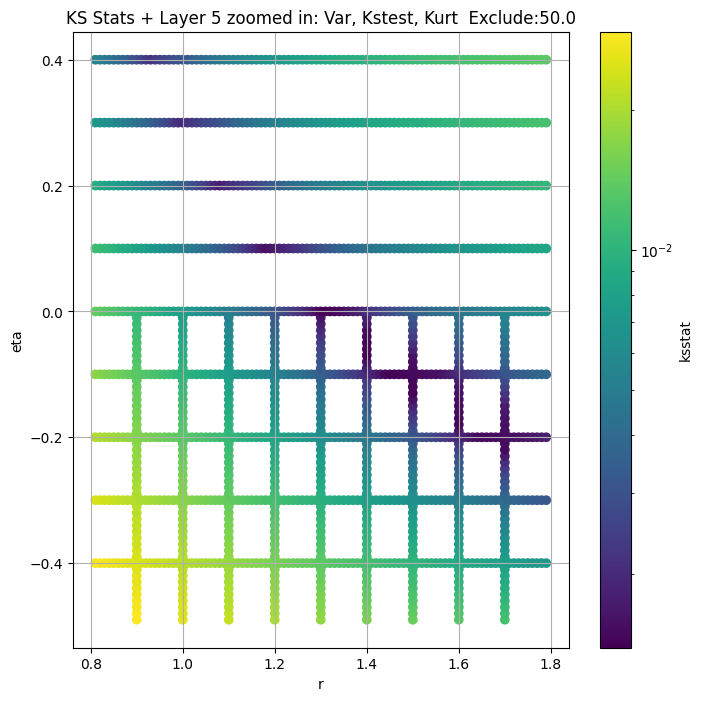

Layer 6


  0%|          | 0/1080 [00:00<?, ?it/s]

Finding Minimum after computing 1080 CDFs
layer 6, 250.0 + 100 = 350, ksstat: 0.006771737249819949, var: 9963.548828125


  0%|          | 0/1080 [00:00<?, ?it/s]

Finding Minimum after computing 1080 CDFs
layer 6, 250.0 + 75 = 325, ksstat: 0.00655373435461166, var: 10100.525390625


  0%|          | 0/1080 [00:00<?, ?it/s]

Finding Minimum after computing 1080 CDFs
layer 6, 250.0 + 50 = 300, ksstat: 0.006320900481905922, var: 10242.474609375


  0%|          | 0/1080 [00:00<?, ?it/s]

Finding Minimum after computing 1080 CDFs
layer 6, 250.0 + 25 = 275, ksstat: 0.006073425791362497, var: 10389.763671875


  0%|          | 0/1080 [00:00<?, ?it/s]

Finding Minimum after computing 1080 CDFs
layer 6, 250.0 + 0 = 250, ksstat: 0.005838181639576279, var: 10542.8876953125


  0%|          | 0/1080 [00:00<?, ?it/s]

Finding Minimum after computing 1080 CDFs
layer 6, 250.0 + -25 = 225, ksstat: 0.005631764336460288, var: 10702.55859375


  0%|          | 0/1080 [00:00<?, ?it/s]

Finding Minimum after computing 1080 CDFs
layer 6, 250.0 + -50 = 200, ksstat: 0.005420229214029737, var: 10869.453125


  0%|          | 0/1080 [00:00<?, ?it/s]

Finding Minimum after computing 1080 CDFs
layer 6, 250.0 + -75 = 175, ksstat: 0.005374049324190569, var: 11044.6494140625


  0%|          | 0/1080 [00:00<?, ?it/s]

Finding Minimum after computing 1080 CDFs
layer 6, 250.0 + -100 = 150, ksstat: 0.005651526843548971, var: 11229.59375
Number of samples: 100000, Without approximation : 3670424


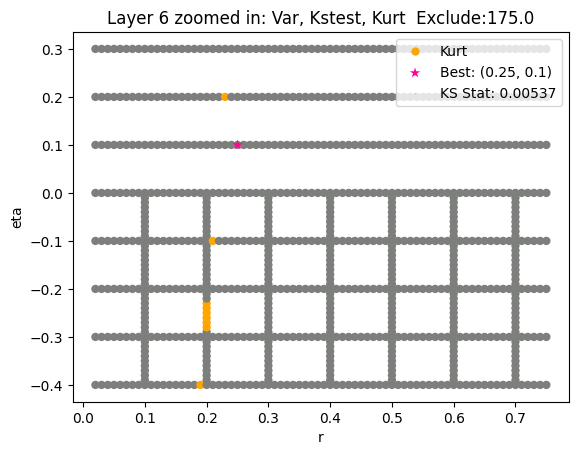

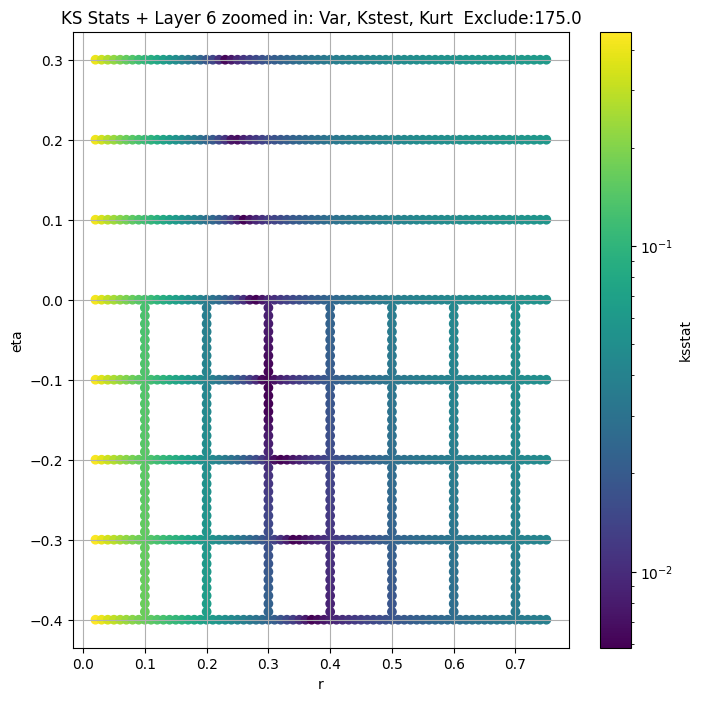

Layer 7


  0%|          | 0/999 [00:00<?, ?it/s]

Finding Minimum after computing 999 CDFs
layer 7, 25.0 + 100 = 125, ksstat: 0.0038703692010940947, var: 1159.327392578125


  0%|          | 0/999 [00:00<?, ?it/s]

Finding Minimum after computing 999 CDFs
layer 7, 25.0 + 75 = 100, ksstat: 0.003506251192599735, var: 1182.999267578125


  0%|          | 0/999 [00:00<?, ?it/s]

Finding Minimum after computing 999 CDFs
layer 7, 25.0 + 50 = 75, ksstat: 0.003133200323001335, var: 1208.66845703125


  0%|          | 0/999 [00:00<?, ?it/s]

Finding Minimum after computing 999 CDFs
layer 7, 25.0 + 25 = 50, ksstat: 0.002814036048956914, var: 1236.966064453125


  0%|          | 0/999 [00:00<?, ?it/s]

Finding Minimum after computing 999 CDFs
layer 7, 25.0 + 0 = 25, ksstat: 0.002682479785817815, var: 1269.202392578125


  0%|          | 0/999 [00:00<?, ?it/s]

Finding Minimum after computing 999 CDFs
layer 7, 25.0 + -25 = 0, ksstat: 0.0023396238966971183, var: 1314.776123046875
Number of samples: 100000, Without approximation : 15384514


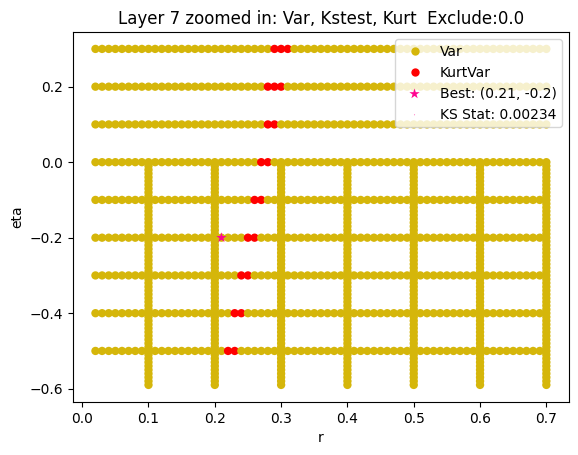

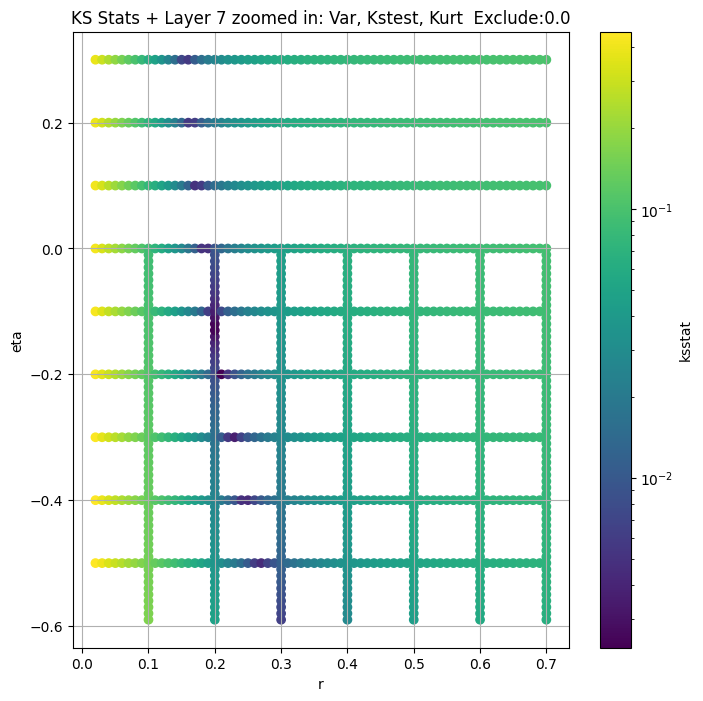

Layer 8


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 8, 0.0 + 100 = 100, ksstat: 0.005268631958095793, var: 45.54209899902344


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 8, 0.0 + 75 = 75, ksstat: 0.0046331915973336635, var: 46.673580169677734


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 8, 0.0 + 50 = 50, ksstat: 0.004031618130890702, var: 48.00090408325195


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 8, 0.0 + 25 = 25, ksstat: 0.0033153432653703213, var: 49.71946334838867


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 8, 0.0 + 0 = 0, ksstat: 0.0018446252168436983, var: 56.88734436035156
Number of samples: 100000, Without approximation : 62976002


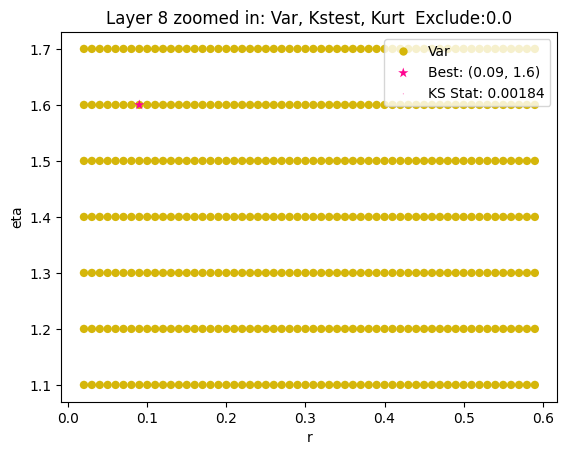

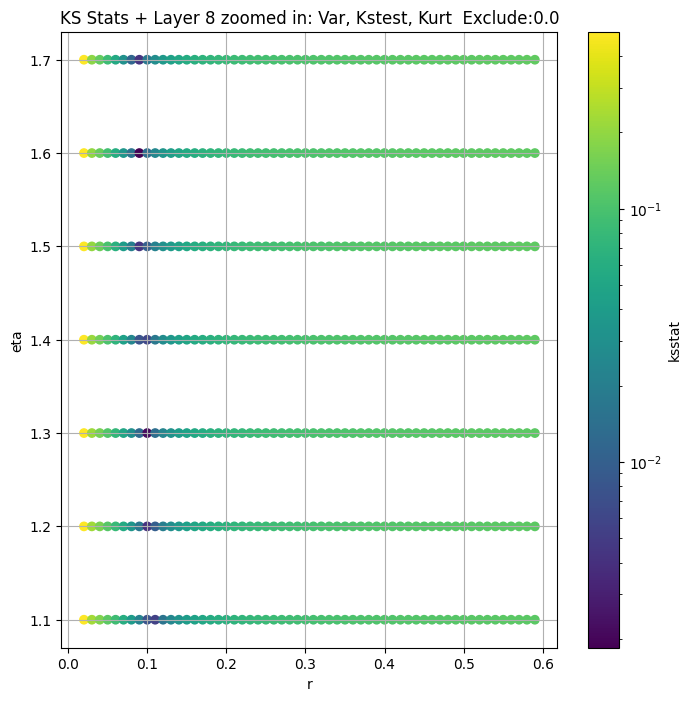

Layer 9


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 9, 300.0 + 100 = 400, ksstat: 0.006642279152619404, var: 1.2010886669158936


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 9, 300.0 + 75 = 375, ksstat: 0.006379457871934169, var: 1.2182117700576782


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 9, 300.0 + 50 = 350, ksstat: 0.00606810657953516, var: 1.2362374067306519


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 9, 300.0 + 25 = 325, ksstat: 0.005776874030636203, var: 1.2552903890609741


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 9, 300.0 + 0 = 300, ksstat: 0.005503076085138003, var: 1.275495171546936


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 9, 300.0 + -25 = 275, ksstat: 0.005493660342212214, var: 1.297007441520691


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 9, 300.0 + -50 = 250, ksstat: 0.005743650686145407, var: 1.3200267553329468


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 9, 300.0 + -75 = 225, ksstat: 0.00612209570652944, var: 1.3447836637496948


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 9, 300.0 + -100 = 200, ksstat: 0.006767239295962568, var: 1.3716115951538086
Number of samples: 100000, Without approximation : 254776200


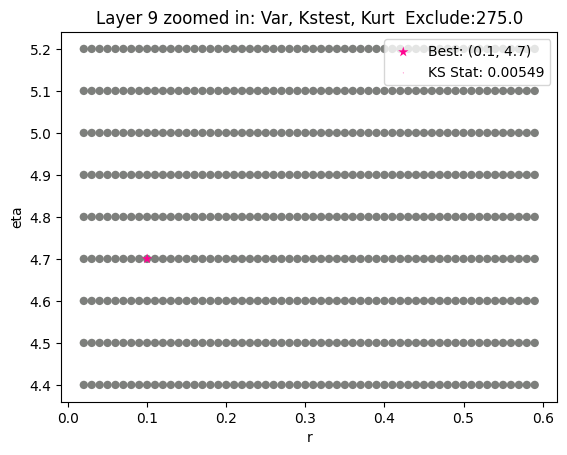

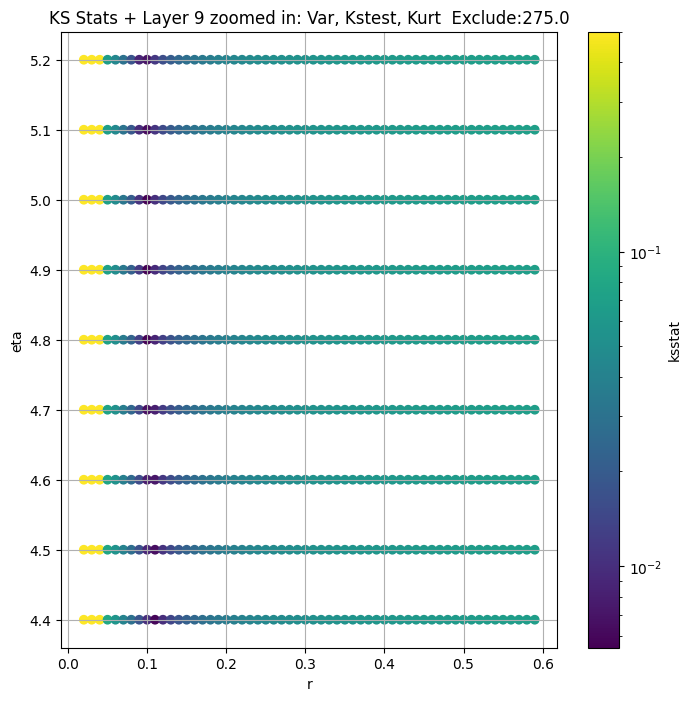

Cannot compute pval with ksstat : nan, n : 0.0


obs_var      var_lower      var_upper    obs_kurt  kurt_lower  \
layer                                                                        
2                NaN            NaN            NaN         NaN         NaN   
3       79735.640000   76177.540000   83407.180000    1.053642    0.821076   
4      129412.030000  124235.086000  134673.400000    0.427118    0.221106   
5       38390.297000   36425.370000   40415.066000    2.094468    1.571328   
6       12667.709000   11567.081000   13817.150000    9.891224    8.672808   
7        1314.776100    1189.517000    1448.287100   12.748015   10.145151   
8          56.887344      47.695780      76.797424   91.038864   11.893420   
9           2.228922       1.633102       4.197240  495.823330   16.132544   

        kurt_upper  total_samples  kstest_stat_initial  initial_r  \
layer                                                               
2              NaN              0                  NaN        NaN   
3         1.318261          19544             0.005436        0.3   
4         0.664810         177766             0.007301        1.8   
5         2.786164         820632             0.001433        1.3   
6        11.163638        3670424             0.005935        0.3   
7        20.341785       15384514             0.002772        0.2   
8       375.473180       62976002             0.002150        0.1   
9      1411.289900      254776200             0.005503        0.1   

       initial_eta  initial_scale  initial_exclude_cutoff  best_augmented_var  \
layer                                                                           
2              NaN            NaN                     NaN                 NaN   
3              5.7   1.710793e+00                     0.0        79735.640625   
4              2.4   8.907592e+04                     0.0       129412.031250   
5              0.0   3.590717e+04                    50.0        37375.437500   
6             -0.1   3.077395e+01                   250.0        11044.649414   
7             -0.1   2.289326e-02                    25.0         1314.776123   
8              1.3   4.500508e-14                     0.0           56.887344   
9              4.8   6.555100e-19                   300.0            1.297007   

       kstest_stat_cutoff_0.05  kstest_stat_best  best_r  best_eta  \
layer                                                                
2                          NaN               NaN     NaN       NaN   
3                     0.009706          0.005421    0.31       5.4   
4                     0.003220          0.007257    1.94       2.2   
5                     0.001499          0.001391    1.31       0.0   
6                     0.000709          0.005374    0.25       0.1   
7                     0.000346          0.002340    0.21      -0.2   
8                     0.000171          0.001845    0.09       1.6   
9                     0.000085          0.005494    0.10       4.7   

         best_scale  best_exclude_cutoff  n_pval_0.05  
layer                                                  
2               NaN                  NaN           -1  
3      3.073072e+00                  0.0        65961  
4      9.896893e+04                  0.0        33330  
5      3.621420e+04                 50.0       923211  
6      2.953474e+00                175.0        64518  
7      6.751591e-02                  0.0       342261  
8      1.073794e-16                  0.0       553500  
9      7.740763e-19                275.0        62201

In [14]:
master_df_optimized_path = Path(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))

NUM_ITERS = dict(zip(GROUPS, [1]*len(GROUPS))) # By default, does one iteration per group
NUM_SAMPLES_OPTIMIZE = 2000
EXCLUDE_CUTOFFS_OPTIMIZE = np.arange(100, -101, -25)

if RERUN or not master_df_optimized_path.exists():

    if SKIP_OPTIMIZE_STEP:

        master_df['kstest_stat_best'] = master_df['kstest_stat_initial']
        master_df[f'best_r'] = master_df['initial_r']
        master_df[f'best_eta'] = master_df['initial_eta']
        master_df[f'best_scale'] = master_df['initial_scale']
        master_df[f'best_exclude_cutoff'] = master_df['initial_exclude_cutoff']

    else:
        for group in GROUPS: # TODO For quick testing purposes
            print(f"{GROUP.capitalize()} {group}")
            master_df.loc[group, 'kstest_stat_best'] = master_df.loc[group, 'kstest_stat_initial']
            master_df.loc[group, 'best_r'] = master_df.loc[group, 'initial_r']
            master_df.loc[group, 'best_eta'] = master_df.loc[group, 'initial_eta']
            master_df.loc[group, 'best_scale'] = master_df.loc[group, 'initial_scale']

            sample = group_data_map[group]
            if len(sample) == 0:
                continue
            initial_r, initial_eta = master_df.loc[group, 'initial_r'], master_df.loc[group, f'initial_eta']
            eps = 0.5
            group_cdfs_df = fine_cdfs_df[(np.abs(master_df.loc[group, 'initial_r'] - fine_cdfs_df['r']) < eps) & 
                                        (np.abs(master_df.loc[group, 'initial_eta'] - fine_cdfs_df['eta']) < eps)].reset_index(drop=True)
            group_cdfs = {x[0]:x[1] for x in group_cdfs_df['(r,eta),cdf']}

            for adjust_exclude_cutoff in EXCLUDE_CUTOFFS_OPTIMIZE: # -50, -25, 0, 25, 50
                
                exclude_cutoff = int(max(0, adjust_exclude_cutoff + master_df.loc[group, 'initial_exclude_cutoff']))
                
                if exclude_cutoff == 0:
                    augmented_var = np.var(group_data_map[group])
                else:
                    augmented_var = np.var(group_data_map[group][exclude_cutoff:-exclude_cutoff])                       

                group_cdfs_df['scale'] = np.clip((augmented_var / group_cdfs_df['variance']), 0,  SCALE_CAP)
                ksstats, initial_param, min_stat = gridsearch(sample, group_cdfs, debug=True, scales=group_cdfs_df['scale'])
                
                cutoff_label = generate_cutoff_label(adjust_exclude_cutoff)

                augmented_var_df.loc[group, f"kstest_stat_{cutoff_label}"] = min_stat
                group_cdfs_df[f'ksstat_exclude_{cutoff_label}'] = ksstats
                
                print(f"{GROUP} {group}, {master_df.loc[group, 'initial_exclude_cutoff']} + {adjust_exclude_cutoff} = {exclude_cutoff}, ksstat: {min_stat}, var: {augmented_var}")
                best_adjust = 0

                if min_stat < master_df.loc[group, 'kstest_stat_best']:

                    inital_min_stat = min_stat
                    inital_best_param = initial_param
                    master_df.loc[group, 'kstest_stat_best'] = min_stat
                    initial_scale = group_cdfs_df.loc[(group_cdfs_df["r"] ==  initial_param[0]) & (group_cdfs_df["eta"] ==  initial_param[1])]["scale"].iloc[0]
                    master_df.loc[group, 'best_r'], master_df.loc[group, 'best_eta'] = initial_param
                    master_df.loc[group, 'best_scale'] = initial_scale
                    master_df.loc[group, 'best_exclude_cutoff'] = exclude_cutoff
                    master_df.loc[group, 'best_augmented_var'] = augmented_var
                    augmented_var_df.loc[group, 'best_augmented_var'] = augmented_var
                    best_adjust = adjust_exclude_cutoff

                if exclude_cutoff == 0:
                    break

            cutoff_label = generate_cutoff_label(best_adjust)
            ksstats = group_cdfs_df[f"ksstat_exclude_{cutoff_label}"]
            
            print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
            
            cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
            master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

            best_scales = np.clip((master_df.loc[group, 'best_augmented_var'] / group_cdfs_df['variance']), 0,  SCALE_CAP)

            group_cdfs_df['variance'] = group_cdfs_df['variance'] * best_scales
            group_cdfs_df['kurtosis'] = group_cdfs_df['kurtosis'] * best_scales

            group_cdfs_df = add_tests_to_df(cdfs_df = group_cdfs_df, group = group, var_kurt_df = master_df, ksstats = ksstats).sort_values(['r', 'eta'])

            group_dict = rEtaKsstats_dict[group]
            group_dict.update({'r_optimize' : group_cdfs_df['r'], 'eta_optimize' : group_cdfs_df['eta'], f'ksstat_exclude_{cutoff_label}' : ksstats})
            rEtaKsstats_dict[group] = group_dict

            cols = ['pass_var', 'pass_kstest', 'pass_kurt']
            fig = combo_test_plot(group_cdfs_df, cols, 
                                plot_name=f"{GROUP.capitalize()} {group} zoomed in: {', '.join([col[5:].capitalize() for col in cols])}  Exclude:{master_df.loc[group, 'best_exclude_cutoff']}",
                                best_param=(master_df.loc[group, 'best_r'], master_df.loc[group, f'best_eta']),
                                best_ksstat=master_df.loc[group, 'kstest_stat_best'])
            fig.figure.savefig(os.path.join(CWD, "plots", f"optimized_full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=100)
            
    master_df['n_pval_0.05'] = master_df.apply(lambda row : find_n_fixed_pval_stat(row.loc['kstest_stat_best'], row.loc['total_samples']), axis = 1)    
    master_df[['total_samples', 'initial_r', 'initial_eta', 'kstest_stat_initial', 'initial_exclude_cutoff', 'best_r', 'best_eta', 'best_scale', 'kstest_stat_best', 'best_exclude_cutoff', 'n_pval_0.05']].to_csv(os.path.join(CWD, "CSVs", 'optimized_params.csv'))
    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))
    augmented_var_df.to_csv(augmented_var_df_path)
    pd.to_pickle(rEtaKsstats_dict, rEtaKsstats_dict_path)

rEtaKsstats_dict = pd.read_pickle(rEtaKsstats_dict_path)
master_df = pd.read_csv(master_df_optimized_path, index_col = GROUP)
augmented_var_df = pd.read_csv(augmented_var_df_path, index_col = GROUP)
master_df

## Comparing Empirical and Computed CDF/PDF

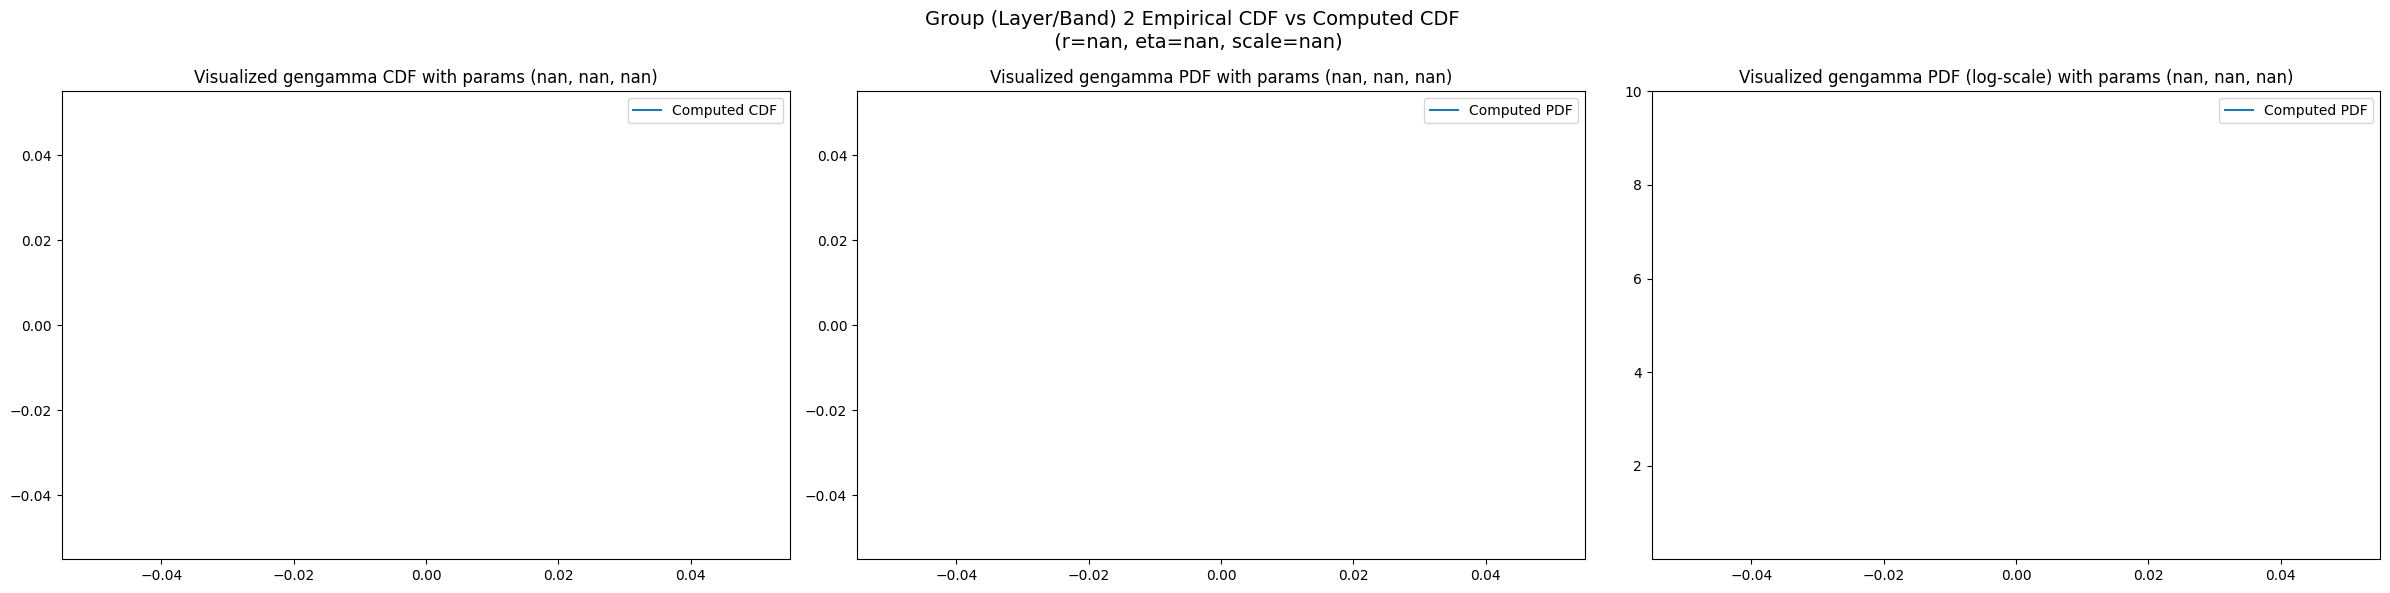

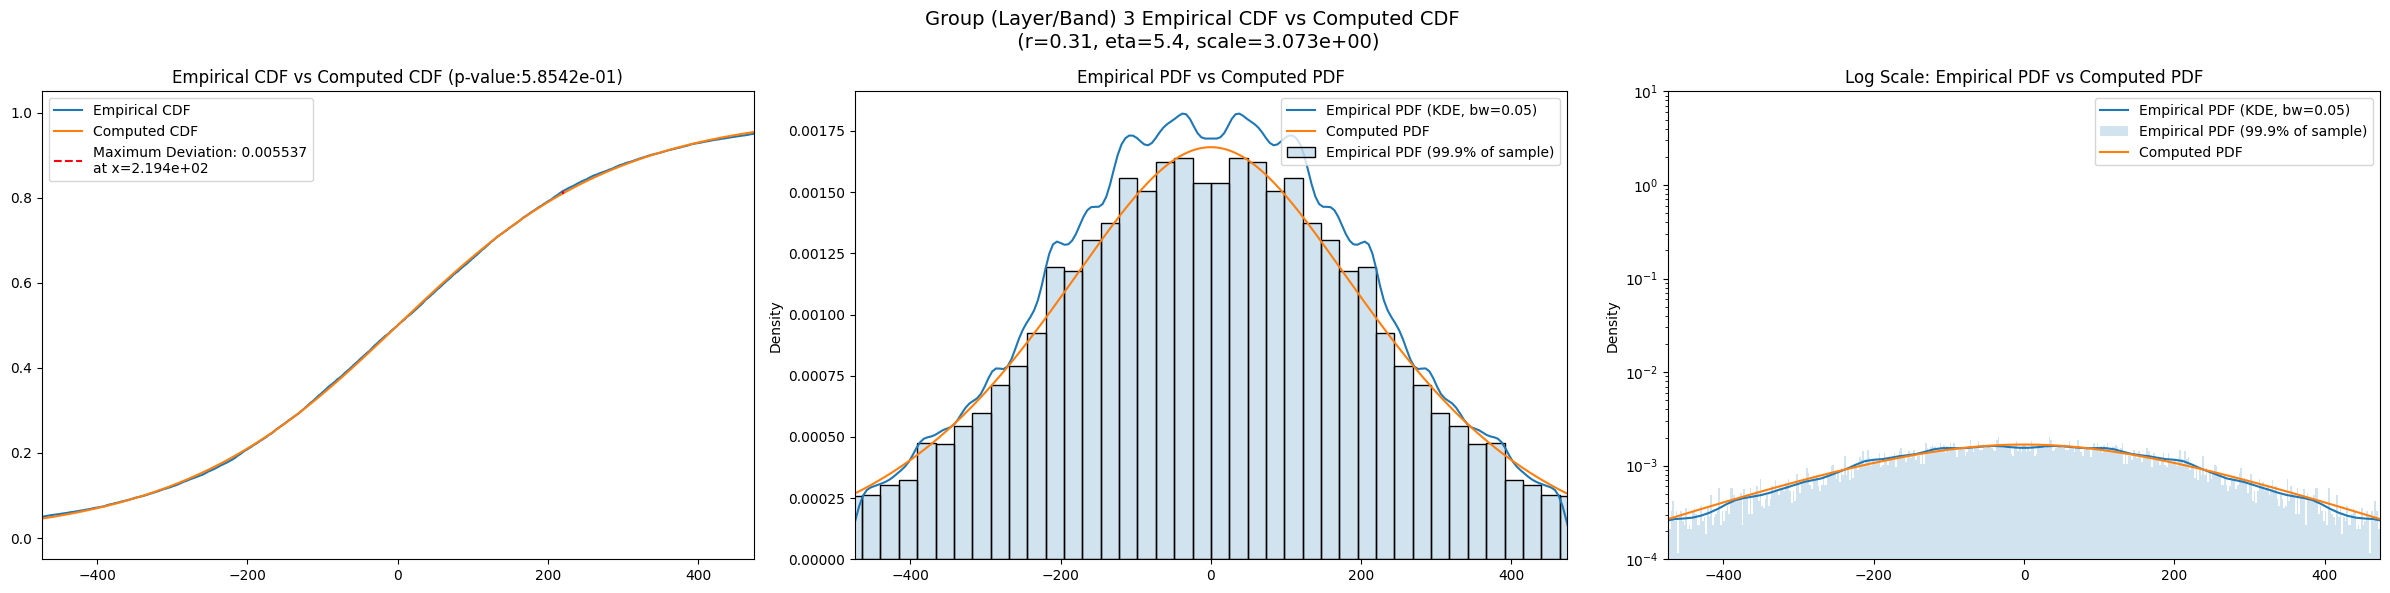

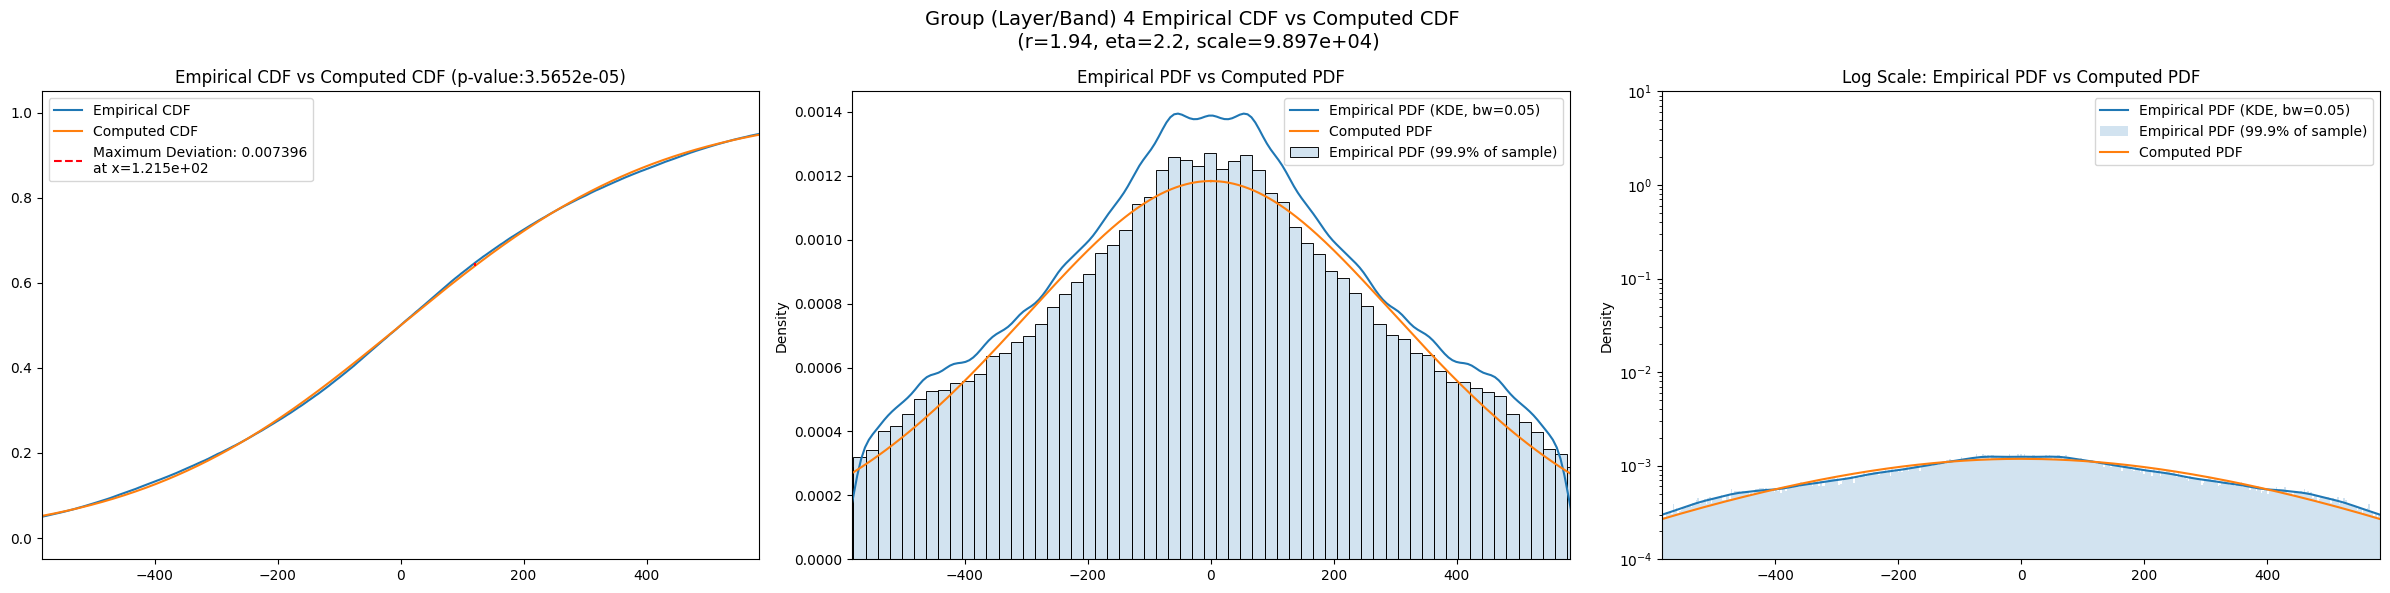

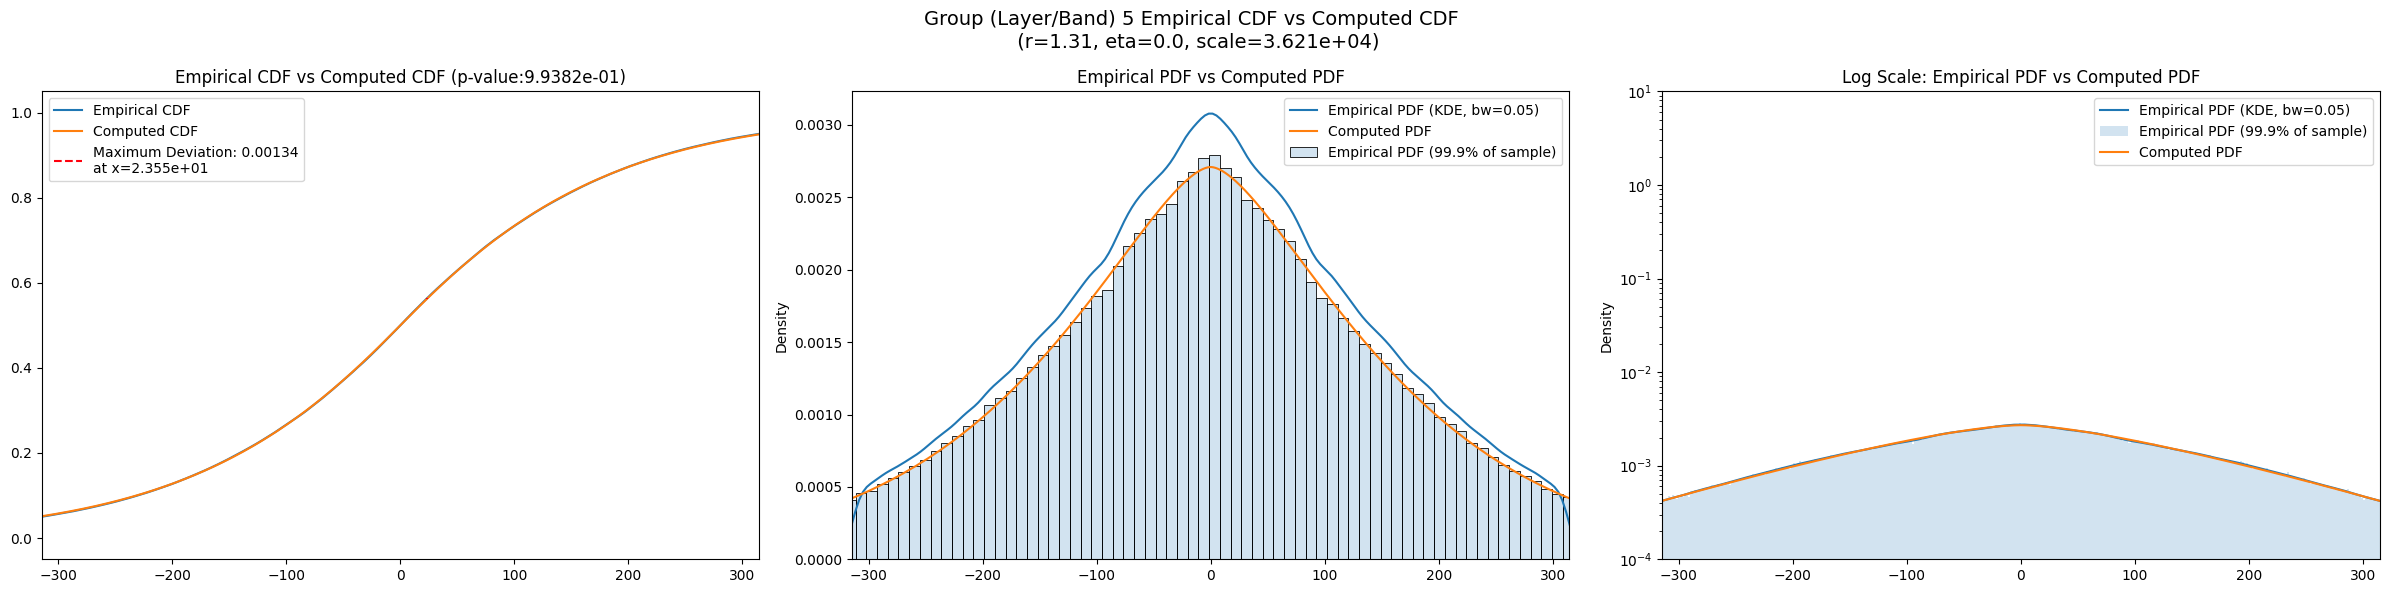

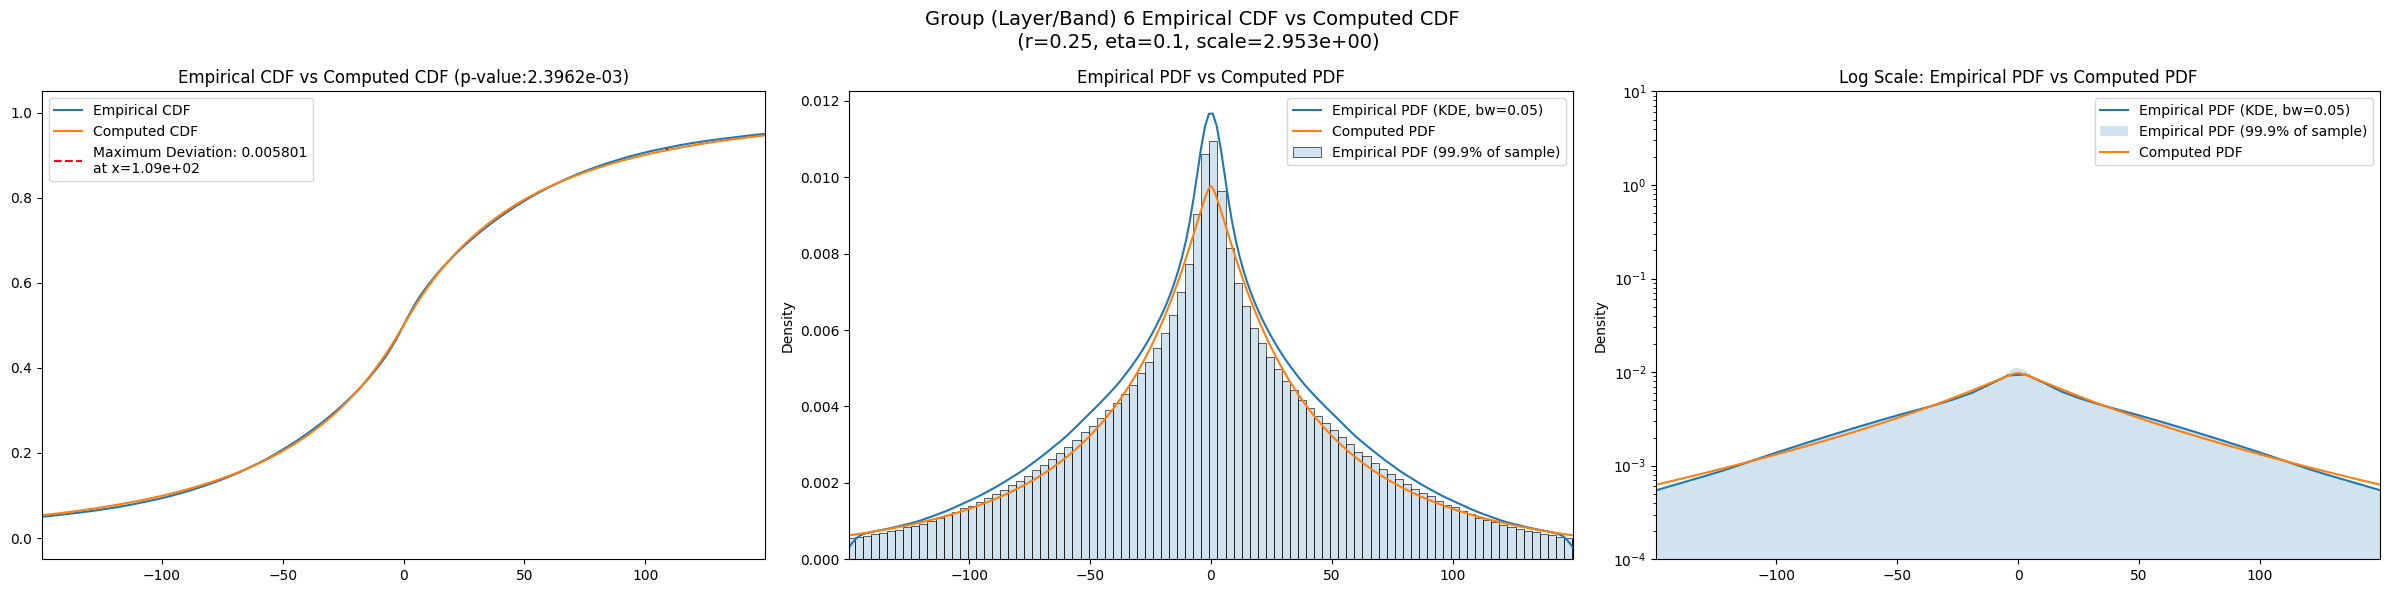

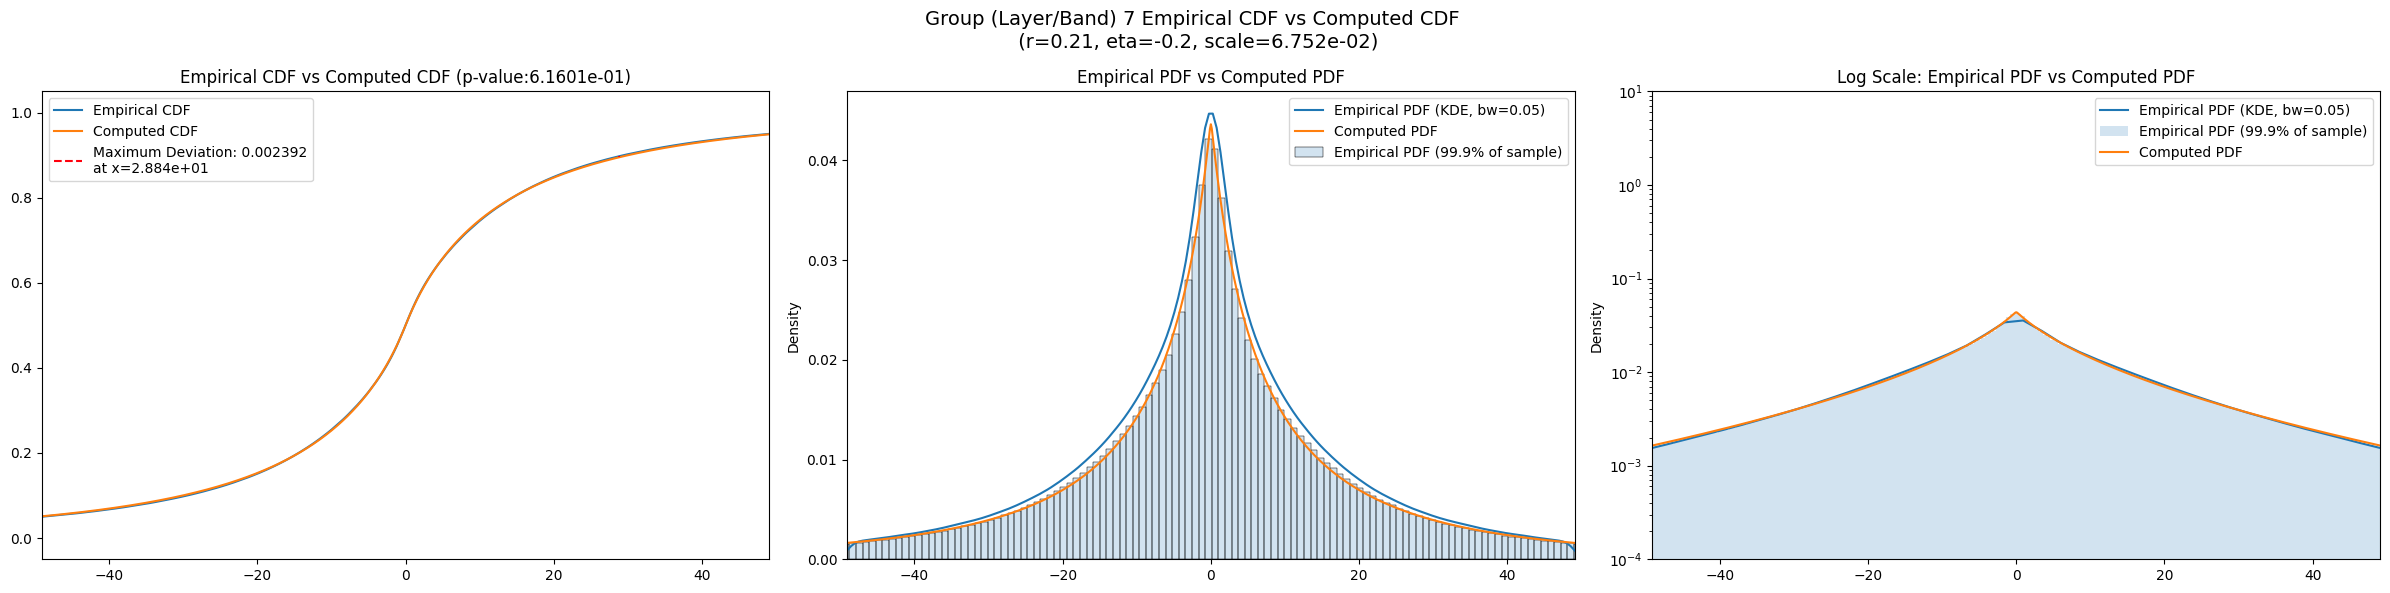

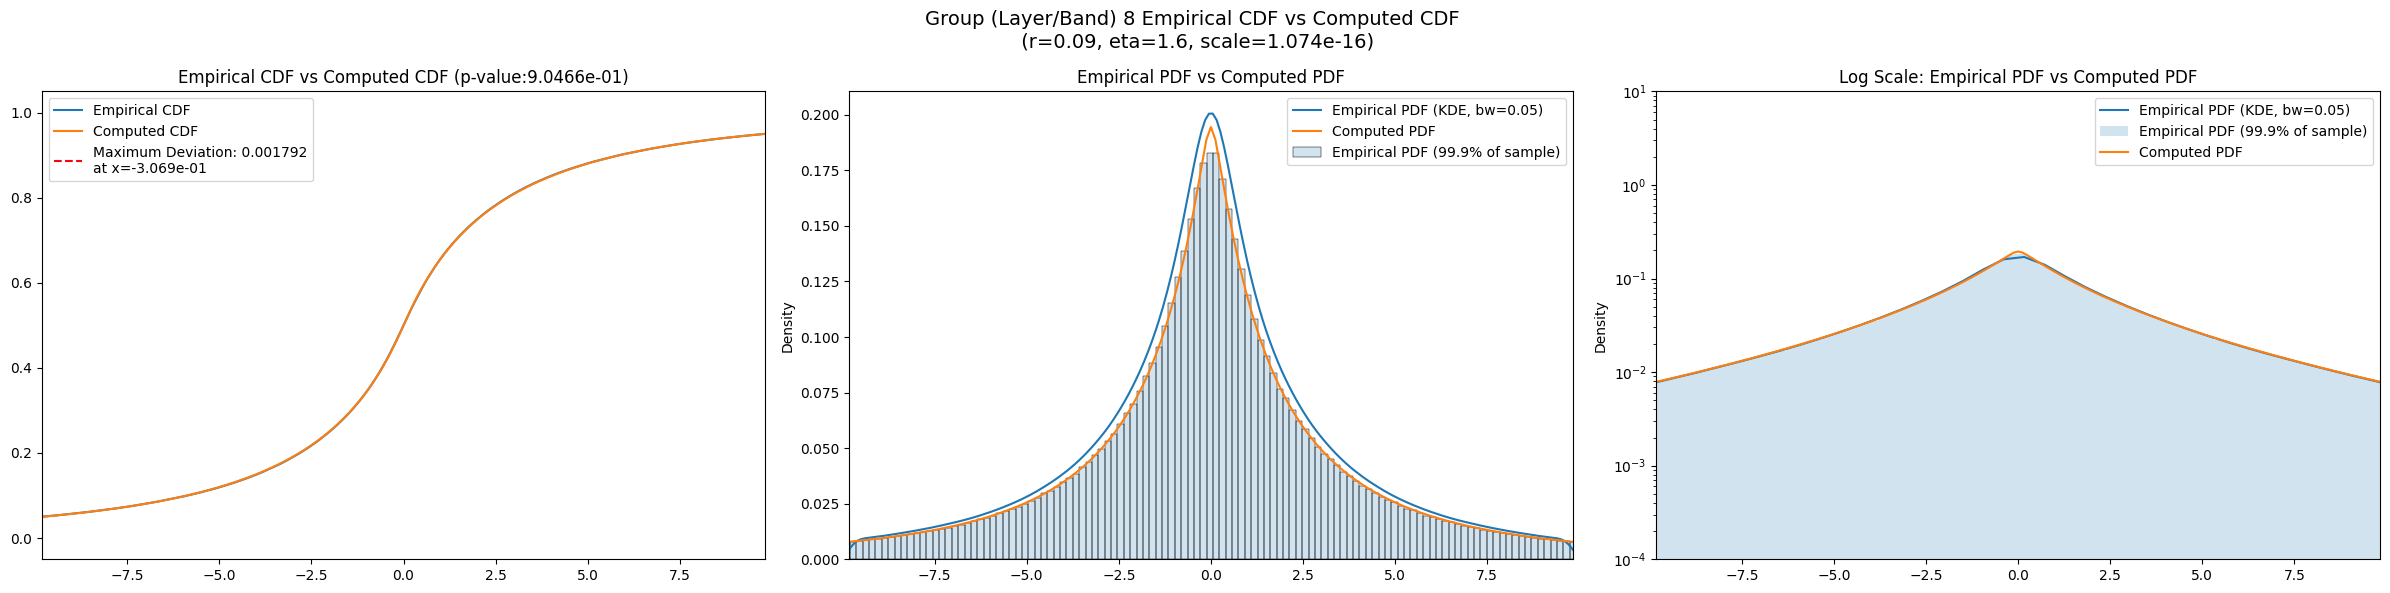

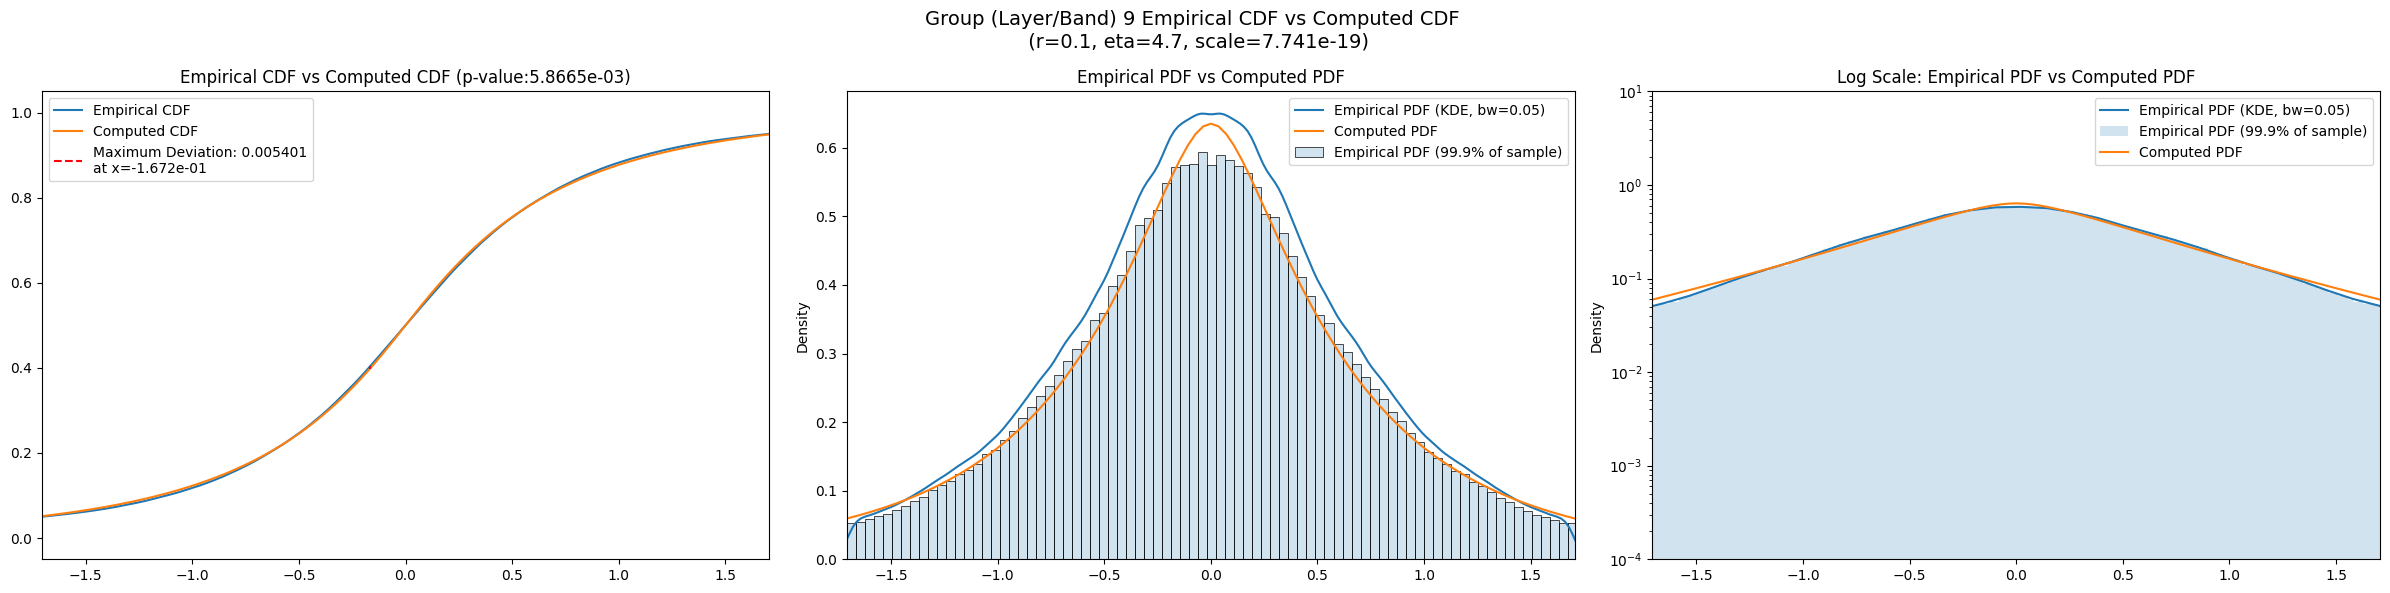

In [15]:
for group in GROUPS:
    group_info = master_df.loc[group]
    best_r = group_info['best_r']
    best_eta = group_info['best_eta']
    best_scale = group_info['best_scale']
    fig = visualize_cdf_pdf(sample = group_data_map[group], 
                    params = (best_r, best_eta, best_scale), 
                    log_scale = True,
                    group = group)
    fig.savefig(os.path.join(CWD, "plots", f'compare_cdf_pdf_layer_{group}.jpg'), bbox_inches = 'tight', dpi = 100)

## Comparing with Gaussian and Laplace Priors

In [16]:
def generate_func(sample, distro, *args, n_samples=200):
    if distro == 'gaussian' or distro == 'normal':
        def var_func(var):
            cdf = scipy.stats.norm(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'laplace':
        def var_func(var):
            cdf = scipy.stats.laplace(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 't':
        def var_func(var):
            cdf = scipy.stats.t(df=2, scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'prior_r':
        eta = args[0]
        def r_func(r):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return r_func
    elif distro == 'prior_eta':
        r = args[0]
        def eta_func(eta):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return eta_func
    elif distro == 'prior':
        def r_eta_func(params):
            r = params[0]
            eta = params[1]
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample, cdf)
        return r_eta_func
    elif distro == 'prior_with_scale':
        def r_eta_scale_func(params):
            r = params[0]
            eta = params[1]
            scale = params[2]
            print(r, eta, scale)
            cdf = compute_prior_cdf(r = r, eta = eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample/ np.sqrt(scale), cdf)
        return r_eta_scale_func

    print("Please enter a valid argument for `distro`: 'gaussian', 'laplace', 'prior_r', 'prior_eta', 'prior','prior_with_scale', 't'")

In [17]:
master_df_path = Path(os.path.join(CWD, "CSVs", 'master_df.csv'))

if RERUN or not master_df_path.exists():
    upper_bound = int(1e6)
    for group in GROUPS:
        if len(group_data_map[group]) == 0:
            continue
        norm_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'gaussian'), method = 'bounded', bounds = (0, upper_bound))
        laplace_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'laplace'), method = 'bounded', bounds = (0, upper_bound))
        t_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 't'), method = 'bounded', bounds = (0, upper_bound))
        
        master_df.loc[group, 'param_gaussian'] = round_to_sigfigs(norm_result['x'], 6)
        master_df.loc[group, 'kstest_stat_gaussian'] = round_to_sigfigs(norm_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_gaussian'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_gaussian']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6) 

        master_df.loc[group, 'param_t'] = round_to_sigfigs(t_result['x'], 6)
        master_df.loc[group, 'kstest_stat_t'] = round_to_sigfigs(t_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_t'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_t']), 6) 

        master_df.loc[group, 'kstest_pval_gengamma'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_best']))

    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df.csv'))
    
master_df = pd.read_csv(os.path.join(CWD, "CSVs", 'master_df.csv'), index_col = GROUP)
master_df

obs_var      var_lower      var_upper    obs_kurt  kurt_lower  \
layer                                                                        
2                NaN            NaN            NaN         NaN         NaN   
3       79735.640000   76177.540000   83407.180000    1.053642    0.821076   
4      129412.030000  124235.086000  134673.400000    0.427118    0.221106   
5       38390.297000   36425.370000   40415.066000    2.094468    1.571328   
6       12667.709000   11567.081000   13817.150000    9.891224    8.672808   
7        1314.776100    1189.517000    1448.287100   12.748015   10.145151   
8          56.887344      47.695780      76.797424   91.038864   11.893420   
9           2.228922       1.633102       4.197240  495.823330   16.132544   

        kurt_upper  total_samples  kstest_stat_initial  initial_r  \
layer                                                               
2              NaN              0                  NaN        NaN   
3         1.318261          19544             0.005436        0.3   
4         0.664810         177766             0.007301        1.8   
5         2.786164         820632             0.001433        1.3   
6        11.163638        3670424             0.005935        0.3   
7        20.341785       15384514             0.002772        0.2   
8       375.473180       62976002             0.002150        0.1   
9      1411.289900      254776200             0.005503        0.1   

       initial_eta  ...  param_gaussian  kstest_stat_gaussian  \
layer               ...                                         
2              NaN  ...             NaN                   NaN   
3              5.7  ...      262.174000              0.016144   
4              2.4  ...      345.582000              0.010029   
5              0.0  ...      172.161000              0.016812   
6             -0.1  ...       65.857500              0.039441   
7             -0.1  ...       18.704000              0.051723   
8              1.3  ...        3.722910              0.052185   
9              4.8  ...        0.837385              0.030319   

       kstest_pval_gaussian  param_laplace  kstest_stat_laplace  \
layer                                                             
2                       NaN            NaN                  NaN   
3              7.439080e-05     233.460000             0.018978   
4              5.847030e-16     295.970000             0.021986   
5             6.535490e-202     151.171000             0.012031   
6              0.000000e+00      58.674900             0.015527   
7              0.000000e+00      16.400000             0.025405   
8              0.000000e+00       3.285320             0.025350   
9              0.000000e+00       0.730297             0.010008   

       kstest_pval_laplace     param_t  kstest_stat_t  kstest_pval_t  \
layer                                                                  
2                      NaN         NaN            NaN            NaN   
3             1.516170e-06  185.975000       0.020831   8.478270e-08   
4             4.482850e-75  243.597000       0.027193  1.240770e-114   
5            1.337720e-103  122.489000       0.016947  3.724920e-205   
6             0.000000e+00   45.718100       0.017064   0.000000e+00   
7             0.000000e+00   12.826000       0.026208   0.000000e+00   
8             0.000000e+00    2.593480       0.024382   0.000000e+00   
9             0.000000e+00    0.598394       0.002104   0.000000e+00   

       kstest_pval_gengamma  
layer                        
2                       NaN  
3              6.119704e-01  
4              1.473197e-08  
5              8.364045e-02  
6              1.683241e-92  
7              1.426985e-73  
8             1.496519e-186  
9              0.000000e+00  

[8 rows x 30 columns]

## Results

In [18]:
import pandas as pd
import os
master_df = pd.read_csv(os.path.join(os.getcwd(), "CSVs", 'master_df.csv'), index_col = 0)

In [19]:
master_df.filter(regex="kstest_stat.*")

kstest_stat_initial  kstest_stat_cutoff_0.05  kstest_stat_best  \
layer                                                                   
2                      NaN                      NaN               NaN   
3                 0.005436                 0.009706          0.005421   
4                 0.007301                 0.003220          0.007257   
5                 0.001433                 0.001499          0.001391   
6                 0.005935                 0.000709          0.005374   
7                 0.002772                 0.000346          0.002340   
8                 0.002150                 0.000171          0.001845   
9                 0.005503                 0.000085          0.005494   

       kstest_stat_gaussian  kstest_stat_laplace  kstest_stat_t  
layer                                                            
2                       NaN                  NaN            NaN  
3                  0.016144             0.018978       0.020831  
4                  0.010029             0.021986       0.027193  
5                  0.016812             0.012031       0.016947  
6                  0.039441             0.015527       0.017064  
7                  0.051723             0.025405       0.026208  
8                  0.052185             0.025350       0.024382  
9                  0.030319             0.010008       0.002104

In [20]:
master_df.filter(regex="best.*")

best_augmented_var  kstest_stat_best  best_r  best_eta    best_scale  \
layer                                                                         
2                     NaN               NaN     NaN       NaN           NaN   
3            79735.640625          0.005421    0.31       5.4  3.073072e+00   
4           129412.031250          0.007257    1.94       2.2  9.896893e+04   
5            37375.437500          0.001391    1.31       0.0  3.621420e+04   
6            11044.649414          0.005374    0.25       0.1  2.953474e+00   
7             1314.776123          0.002340    0.21      -0.2  6.751591e-02   
8               56.887344          0.001845    0.09       1.6  1.073794e-16   
9                1.297007          0.005494    0.10       4.7  7.740763e-19   

       best_exclude_cutoff  
layer                       
2                      NaN  
3                      0.0  
4                      0.0  
5                     50.0  
6                    175.0  
7                      0.0  
8                      0.0  
9                    275.0

In [21]:
eng.quit()